<a href="https://colab.research.google.com/github/nadeem414/SimCLR/blob/master/notebooks/how-to-finetune-florence-2-on-detection-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Configure your API keys

To fine-tune Florence-2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `L4 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Tue Aug 27 12:21:16 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.10              Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5500 Laptop GPU    On  |   00000000:01:00.0  On |                  Off |
| N/A   53C    P8             22W /   90W |    2981MiB /  16384MiB |     22%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Download example data

**NOTE:** Feel free to replace our example image with your own photo.

In [ ]:
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!ls -lh

total 108K
-rw-r--r-- 1 root root 104K Jun  2  2023 dog.jpeg
drwxr-xr-x 1 root root 4.0K Jun 25 17:40 sample_data


In [54]:
# EXAMPLE_IMAGE_PATH = "/data/mnt/h/v8_target_selected/60c7f6c50850d39e706ca827.jpg"
EXAMPLE_IMAGE_PATH = "/data/mnt/c/Users/nr54882/Downloads/file-MSaebjyA/export/data/66bfc7afdb960d1cda5d04e6_compressed.jpg"
# EXAMPLE_IMAGE_PATH = "/data/mnt/c/Users/nr54882/Downloads/file-MSaebjyA/export/data/66c5692fe9d8dd3c99093f0b_compressed.jpg"

## Download and configure the model

 Let's download the model checkpoint and configure it so that you can fine-tune it later on.

In [ ]:
!pip install -q transformers flash_attn timm einops peft
!pip install -q roboflow git+https://github.com/roboflow/supervision.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 36.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.8 MB/s eta 0:00:00


In [4]:
# @title Imports

import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
import supervision as sv

from google.colab import userdata
from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
# from roboflow import Roboflow

Load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor` classes from the transformers library. Note that you need to pass `trust_remote_code` as `True` since this model is not a standard transformers model.

In [5]:
CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


## Run inference with pre-trained Florence-2 model

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


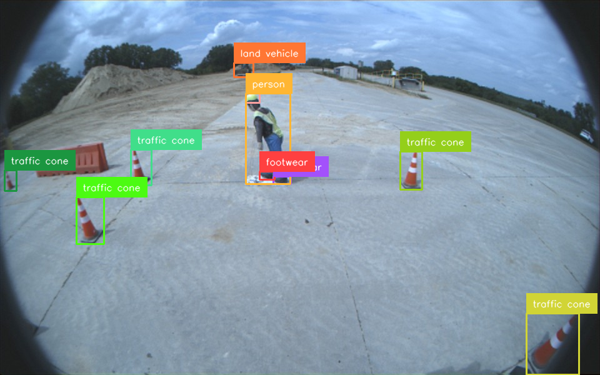

In [65]:
# @title Example object detection inference

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<OD>"
text = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=2048,
    num_beams=25,
    early_stopping=False
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [71]:
detections

Detections(xyxy=array([[437.28    , 282.30002 , 465.12    , 294.30002 ],
       [415.19998 , 274.5     , 439.19998 , 287.1     ],
       [393.12    , 149.70001 , 415.19998 , 164.70001 ],
       [374.88    , 100.50001 , 405.6     , 123.3     ],
       [393.12    , 149.70001 , 464.16    , 294.30002 ],
       [842.39996 , 501.90002 , 926.88    , 599.10004 ],
       [122.399994, 315.30002 , 166.56    , 390.30002 ],
       [640.8     , 242.1     , 675.36    , 303.90002 ],
       [209.76    , 239.1     , 242.4     , 296.7     ],
       [  7.2     , 272.1     ,  26.4     , 305.7     ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'footwear', 'helmet', 'land vehicle', 'person',
       'traffic cone', 'traffic cone', 'traffic cone', 'traffic cone',
       'traffic cone'], dtype='<U12')})

In [91]:
def process_image(image_path):
    # Open the image
    image = Image.open(image_path)
    task = "<OD>"
    text = "<OD>"

    # Prepare inputs
    inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=2048,
        num_beams=25,
        early_stopping=False
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
    detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

    # Annotate the image
    bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
    label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

    image = bounding_box_annotator.annotate(image, detections)
    image = label_annotator.annotate(image, detections)
    image.thumbnail((960, 600))

    # Save or display the image
    output_path = os.path.join("/data/mnt/c/Users/nr54882/Downloads/file-MSaebjyA/export/florence-out", os.path.basename(image_path))
    image.save(output_path)
    OUTPUT_DIR = "/data/mnt/c/Users/nr54882/Downloads/file-MSaebjyA/export/florence-out"
    text_output_path = os.path.join(OUTPUT_DIR, os.path.splitext(os.path.basename(image_path))[0] + ".txt")
    print (detections)
    with open(text_output_path, "w") as text_file:
        for i in range(len(detections)):
            box = detections.xyxy[i]
            label = detections.data['class_name'][i]
            text_file.write(f"Label: {label}\n")
            text_file.write(f"Bounding Box: {box.tolist()}\n\n")


In [92]:
IMAGE_DIR = "/data/mnt/c/Users/nr54882/Downloads/file-MSaebjyA/export/data"
if not os.path.exists("/data/mnt/c/Users/nr54882/Downloads/file-MSaebjyA/export/florence-out"):
    os.makedirs("/data/mnt/c/Users/nr54882/Downloads/file-MSaebjyA/export/florence-out")

# Process all images in the directory
for filename in os.listdir(IMAGE_DIR):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(IMAGE_DIR, filename)
        process_image(image_path)

print("Image processing completed.")

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[590.88,  82.5 , 827.04, 213.3 ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['land vehicle'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['vehicle'], dtype='<U7')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[252.95999, 467.1    , 396.96   , 578.7    ],
       [123.36   , 416.1    , 224.15999, 524.10004],
       [123.36   , 416.1    , 397.91998, 599.10004]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'footwear', 'person'], dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[437.28    , 282.30002 , 465.12    , 294.30002 ],
       [415.19998 , 274.5     , 439.19998 , 287.1     ],
       [393.12    , 149.70001 , 415.19998 , 164.70001 ],
       [374.88    , 100.50001 , 405.6     , 123.3     ],
       [393.12    , 149.70001 , 464.16    , 294.30002 ],
       [842.39996 , 501.90002 , 926.88    , 599.10004 ],
       [122.399994, 315.30002 , 166.56    , 390.30002 ],
       [640.8     , 242.1     , 675.36    , 303.90002 ],
       [209.76    , 239.1     , 242.4     , 296.7     ],
       [  7.2     , 272.1     ,  26.4     , 305.7     ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'footwear', 'helmet', 'land vehicle', 'person',
       'traffic cone', 'traffic cone', 'traffic cone', 'traffic cone',
       'traffic cone'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['land vehicle'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[427.68    , 255.3     , 452.63998 , 266.1     ],
       [400.8     , 249.3     , 420.96    , 260.1     ],
       [386.4     , 147.90001 , 404.63998 , 168.90001 ],
       [386.4     , 147.90001 , 450.72    , 266.1     ],
       [770.39996 , 384.30002 , 832.8     , 479.7     ],
       [ 43.68    , 395.7     , 103.2     , 482.1     ],
       [156.      , 281.7     , 187.68    , 347.1     ],
       [592.8     , 215.70001 , 623.51996 , 267.90002 ],
       [219.36    , 224.70001 , 245.28    , 275.1     ],
       [ 12.96    , 266.7     ,  29.279999, 298.5     ],
       [429.59998 , 255.90001 , 448.8     , 265.5     ],
       [402.72    , 249.90001 , 419.03998 , 259.5     ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'footwear', 'helmet', 'person', 'traffic cone',
       'traffic cone', 'traffic cone', 'traffic cone', 'traffic cone',
       'traffic cone', 'walking shoe', 'walking shoe'], dtype='<U

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[516.95996, 480.90002, 564.95996, 506.7    ],
       [566.88   , 506.1    , 616.8    , 527.7    ],
       [495.84   , 247.50002, 558.24   , 290.1    ],
       [495.84   , 247.50002, 639.83997, 527.10004],
       [118.56   , 386.7    , 184.8    , 484.50003],
       [847.19995, 399.90002, 906.72   , 486.90002]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'footwear', 'helmet', 'person', 'traffic cone',
       'traffic cone'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['land vehicle'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[455.52   , 353.1    , 472.8    , 374.1    ],
       [516.95996, 465.90002, 559.2    , 486.90002],
       [468.     , 187.5    , 516.     , 252.3    ],
       [455.52   , 187.5    , 567.83997, 486.30002],
       [442.08   , 435.30002, 577.44   , 491.1    ],
       [817.44   , 371.7    , 875.04   , 460.50003],
       [126.24   , 345.90002, 180.     , 437.1    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['baseball glove', 'footwear', 'helmet', 'person', 'skateboard',
       'traffic cone', 'traffic cone'], dtype='<U14')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['building'], dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[346.08   , 387.30002, 549.6    , 527.7    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['dog'], dtype='<U3')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02],
       [4.7999999e-01, 8.6700005e+01, 1.7039999e+02, 3.2130002e+02],
       [1.5792000e+02, 1.2750001e+02, 2.3856000e+02, 1.8930000e+02],
       [1.0128000e+02, 2.2110001e+02, 1.4736000e+02, 2.7690002e+02],
       [2.1744000e+02, 1.5570001e+02, 2.3567999e+02, 1.7790001e+02],
       [1.9823999e+02, 1.6530000e+02, 2.1839999e+02, 1.8390001e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['building', 'land vehicle', 'land vehicle', 'wheel', 'wheel',
       'wheel'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['building'], dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['building'], dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['building'], dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['picture frame'], dtype='<U13')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['land vehicle'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['television'], dtype='<U10')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['vehicle'], dtype='<U7')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['vehicle'], dtype='<U7')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['land vehicle'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['building'], dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['land vehicle'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[3.0000000e+02, 5.4990002e+02, 3.1151999e+02, 5.5770001e+02],
       [4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['bolt', 'vehicle'], dtype='<U7')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['land vehicle'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[ 32.16    , 177.3     , 180.      , 258.90002 ],
       [121.439995, 155.70001 , 250.08    , 211.50002 ],
       [102.24    , 227.70001 , 132.95999 , 257.7     ],
       [189.59999 , 185.70001 , 220.31999 , 211.50002 ],
       [ 41.76    , 239.70001 ,  68.64    , 264.30002 ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['land vehicle', 'land vehicle', 'wheel', 'wheel', 'wheel'],
      dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[483.36   , 254.70001, 560.16   , 369.90002],
       [414.24   , 254.70001, 488.16   , 371.1    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['barrel', 'barrel'], dtype='<U6')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[597.6     , 202.50002 , 626.39996 , 261.90002 ],
       [481.44    ,  98.700005, 516.95996 , 111.9     ],
       [790.56    , 138.3     , 816.48    , 153.90001 ],
       [743.51996 , 122.100006, 766.56    , 135.3     ],
       [589.92    , 101.100006, 611.04    , 109.50001 ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['fire hydrant', 'land vehicle', 'land vehicle', 'land vehicle',
       'land vehicle'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[804.     , 372.30002, 838.56   , 405.30002],
       [689.76   , 372.30002, 848.16   , 599.10004],
       [618.72   , 333.90002, 716.63995, 469.50003],
       [416.16   , 234.90001, 498.72   , 337.5    ],
       [194.4    , 221.70001, 228.95999, 310.5    ],
       [ 74.4    , 208.50002, 100.32   , 269.1    ],
       [275.04   , 172.5    , 300.     , 213.90001],
       [207.84   , 165.3    , 223.2    , 192.3    ],
       [187.68   , 155.1    , 199.2    , 172.5    ],
       [689.76   , 529.5    , 804.95996, 599.10004]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['helmet', 'person', 'scone', 'scone', 'scone', 'scone', 'scone',
       'scone', 'scone', 'trousers'], dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[613.92    , 460.50003 , 629.27997 , 471.90002 ],
       [206.87999 , 145.5     , 238.56    , 168.90001 ],
       [544.8     , 293.7     , 606.24    , 348.90002 ],
       [551.51996 , 332.1     , 591.83997 , 381.90002 ],
       [468.      , 293.7     , 630.24    , 590.7     ],
       [335.52    , 165.3     , 363.36    , 216.3     ],
       [644.64    , 349.5     , 748.32    , 526.5     ],
       [839.51996 , 413.1     , 954.72    , 560.7     ],
       [222.23999 , 240.3     , 308.63998 , 356.7     ],
       [630.24    , 230.1     , 697.44    , 328.5     ],
       [843.36    , 300.30002 , 910.56    , 397.50003 ],
       [355.68    , 237.3     , 399.84    , 366.90002 ],
       [455.52    , 195.90001 , 493.91998 , 268.5     ],
       [868.32    , 210.90001 , 887.51996 , 253.50002 ],
       [ 42.719997, 222.90001 ,  61.92    , 252.3     ],
       [ 94.56    , 205.50002 , 108.96    , 226.50002 ],
       [175.2     , 175.5     , 186.72    , 197.1     ],
       [540.959

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[6.4751996e+02, 3.0000001e-01, 9.5856000e+02, 2.2890001e+02],
       [8.2415997e+02, 1.4730000e+02, 8.7215997e+02, 2.1450002e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['land vehicle', 'wheel'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[285.6     , 233.1     , 324.      , 270.30002 ],
       [294.24    , 255.90001 , 321.12    , 289.5     ],
       [257.75998 , 233.1     , 386.4     , 499.50003 ],
       [333.6     , 165.3     , 362.4     , 216.90001 ],
       [648.48    ,  70.5     , 661.92    , 167.1     ],
       [643.68    , 349.5     , 747.36    , 526.5     ],
       [837.6     , 413.1     , 953.75995 , 561.30005 ],
       [629.27997 , 230.70001 , 695.51996 , 328.5     ],
       [842.39996 , 301.5     , 908.63995 , 397.50003 ],
       [243.36    , 240.90001 , 291.36    , 341.1     ],
       [454.56    , 195.90001 , 492.      , 268.5     ],
       [359.52    , 237.3     , 386.4     , 323.1     ],
       [325.91998 , 212.1     , 352.8     , 234.90001 ],
       [ 42.719997, 223.50002 ,  59.039997, 251.70001 ],
       [ 93.6     , 205.50002 , 107.04    , 226.50002 ],
       [174.23999 , 175.5     , 184.8     , 196.50002 ],
       [346.08    , 147.3     , 358.56    , 162.90001 ],
       [323.039

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[6.3791998e+02, 3.0000001e-01, 9.4032001e+02, 2.3850002e+02],
       [4.6895999e+02, 2.0670001e+02, 5.2176001e+02, 3.0270001e+02],
       [8.0015997e+02, 1.5630000e+02, 8.4144000e+02, 2.1450002e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['land vehicle', 'person', 'wheel'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[504.47998 , 217.50002 , 519.83997 , 239.1     ],
       [648.48    ,  14.700001, 945.12    , 237.90001 ],
       [483.36    , 214.50002 , 535.2     , 313.5     ],
       [814.56    , 154.5     , 857.76    , 217.50002 ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['human face', 'land vehicle', 'person', 'wheel'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[5.1695996e+02, 3.2010001e+02, 5.4095996e+02, 3.5130002e+02],
       [6.5903998e+02, 3.0000001e-01, 9.4415997e+02, 2.3970001e+02],
       [4.8144000e+02, 3.1470001e+02, 5.6208002e+02, 4.5390002e+02],
       [8.4719995e+02, 1.6050000e+02, 9.0191998e+02, 2.3430000e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['human face', 'land vehicle', 'person', 'wheel'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[420.96    , 118.50001 , 594.72    , 206.1     ],
       [564.      , 117.3     , 679.2     , 174.3     ],
       [771.36    , 141.3     , 857.76    , 187.5     ],
       [410.4     ,  86.700005, 478.56    , 114.3     ],
       [506.4     ,  91.5     , 553.44    , 112.50001 ],
       [357.6     ,  90.3     , 387.36    , 108.9     ],
       [474.72    ,  86.700005, 502.56    , 103.50001 ],
       [386.4     ,  88.5     , 417.12    , 102.3     ],
       [675.36    , 108.3     , 701.27997 , 121.50001 ],
       [601.44    ,  95.100006, 626.39996 , 105.9     ],
       [641.76    ,  99.9     , 662.88    , 110.700005],
       [281.75998 ,  62.100002, 369.12    , 137.1     ],
       [215.51999 ,  78.9     , 272.16    , 146.70001 ],
       [567.83997 , 155.1     , 581.27997 , 164.70001 ],
       [497.75998 , 170.1     , 535.2     , 206.1     ],
       [421.91998 , 152.70001 , 448.8     , 180.90001 ],
       [623.51996 , 152.70001 , 648.48    , 173.70001 ],
       [831.839

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.9487997e+02, 2.7450000e+02, 5.1503998e+02, 3.0270001e+02],
       [6.4559998e+02, 3.0000001e-01, 9.4415997e+02, 2.3550002e+02],
       [4.6703998e+02, 2.6850000e+02, 5.3615997e+02, 4.1310001e+02],
       [8.3376001e+02, 1.5690001e+02, 8.8176001e+02, 2.2590001e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['human face', 'land vehicle', 'person', 'wheel'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[5.0351999e+02, 3.7950000e+02, 5.3135999e+02, 4.1550003e+02],
       [6.5327997e+02, 3.0000001e-01, 9.4223999e+02, 2.5230000e+02],
       [4.6607999e+02, 3.7290002e+02, 5.5727997e+02, 5.9910004e+02],
       [8.5295996e+02, 1.7250000e+02, 9.0767999e+02, 2.4930000e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['human face', 'land vehicle', 'person', 'wheel'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[277.91998, 170.1    , 401.75998, 312.90002]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['trash bin/can'], dtype='<U13')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[489.12   , 465.90002, 585.12   , 576.30005],
       [408.47998, 398.1    , 471.84   , 470.7    ],
       [358.56   , 398.1    , 540.95996, 585.30005],
       [457.44   , 562.5    , 478.56   , 585.30005]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['fire hydrant', 'helmet', 'person', 'sneakers'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 2.9850000e+02, 5.3279999e+01, 3.8070001e+02],
       [5.8032001e+02, 4.1310001e+02, 6.0912000e+02, 4.3890002e+02],
       [6.0720001e+02, 4.0230002e+02, 6.3600000e+02, 4.1790002e+02],
       [5.7839996e+02, 1.9050000e+02, 6.7151996e+02, 4.3890002e+02],
       [5.8320001e+02, 4.0590002e+02, 6.0720001e+02, 4.3830002e+02],
       [6.1007996e+02, 3.9930002e+02, 6.3407996e+02, 4.1730002e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['car', 'footwear', 'footwear', 'person', 'sneakers', 'sneakers'],
      dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[238.56    , 383.1     , 306.72    , 480.90002 ],
       [380.63998 ,  68.700005, 430.56    , 109.50001 ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['fire hydrant', 'land vehicle'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[315.36   , 299.1    , 356.63998, 317.7    ],
       [408.47998, 279.30002, 436.31998, 303.90002],
       [317.28   , 174.90001, 464.16   , 317.7    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'footwear', 'person'], dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[474.72   , 355.5    , 552.48   , 476.7    ],
       [624.48   , 152.1    , 648.48   , 170.1    ],
       [590.88   , 152.1    , 648.48   , 327.30002],
       [602.39996, 312.30002, 625.44   , 327.30002],
       [595.68   , 300.30002, 607.2    , 311.1    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['fire hydrant', 'helmet', 'person', 'sneakers', 'sneakers'],
      dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[852.95996 , 234.3     , 958.56    , 401.1     ],
       [796.32    , 215.70001 , 937.44    , 299.1     ],
       [679.2     , 109.50001 , 791.51996 , 154.5     ],
       [474.72    , 104.700005, 574.56    , 149.1     ],
       [719.51996 , 120.9     , 787.68    , 146.1     ],
       [818.39996 , 149.1     , 857.76    , 171.90001 ],
       [679.2     , 116.100006, 713.76    , 137.70001 ],
       [526.56    ,  93.3     , 561.12    , 106.50001 ],
       [247.2     , 170.1     , 301.91998 , 322.5     ],
       [285.6     , 306.90002 , 301.91998 , 322.5     ],
       [893.27997 ,  90.3     , 903.83997 , 179.70001 ],
       [475.68    , 104.700005, 573.6     , 149.70001 ],
       [914.39996 , 353.1     , 958.56    , 401.1     ],
       [841.44    , 265.5     , 872.16    , 299.1     ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'person',
       'sneakers

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[531.36    , 366.30002 , 574.56    , 403.50003 ],
       [498.72    , 366.30002 , 526.56    , 405.30002 ],
       [511.19998 ,  93.3     , 541.92    , 128.1     ],
       [470.87997 ,  56.100002, 578.39996 , 405.30002 ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'footwear', 'human face', 'person'], dtype='<U10')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[391.19998 , 193.50002 , 419.03998 , 242.1     ],
       [397.91998 ,  76.5     , 445.91998 , 113.700005]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['fire hydrant', 'land vehicle'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[391.19998 ,  65.700005, 413.28    ,  96.9     ],
       [352.8     ,  51.9     , 442.08    , 310.5     ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['human face', 'person'], dtype='<U10')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[389.28   , 272.1    , 412.31998, 297.90002],
       [361.44   , 263.1    , 382.56   , 282.30002],
       [354.72   , 147.90001, 427.68   , 297.90002]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'footwear', 'person'], dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[347.03998, 397.50003, 376.8    , 419.7    ],
       [293.28   , 430.50003, 321.12   , 453.30002],
       [148.31999, 162.3    , 422.88   , 317.7    ],
       [257.75998, 236.70001, 375.84   , 453.30002],
       [205.92   , 261.30002, 266.4    , 317.1    ],
       [367.19998, 205.50002, 413.28   , 249.90001]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'footwear', 'land vehicle', 'person', 'wheel', 'wheel'],
      dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 4.4370001e+02, 1.2720000e+02, 5.9910004e+02],
       [5.9664001e+02, 5.1330005e+02, 6.4944000e+02, 5.6610004e+02],
       [5.5727997e+02, 5.1330005e+02, 6.5039996e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['car', 'helmet', 'person'], dtype='<U6')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[519.83997 , 183.3     , 527.51996 , 192.90001 ],
       [521.76    , 125.100006, 537.12    , 144.3     ],
       [476.63998 , 125.100006, 536.16    , 232.50002 ],
       [575.51996 , 109.50001 , 589.92    , 134.1     ],
       [516.      , 221.70001 , 534.24    , 230.1     ],
       [477.59998 , 225.3     , 489.12    , 232.50002 ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['baseball glove', 'hat', 'person', 'person', 'walking shoe',
       'walking shoe'], dtype='<U14')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02],
       [7.6463995e+02, 1.4550000e+02, 8.2607996e+02, 1.7370001e+02],
       [6.1295996e+02, 1.0350001e+02, 6.6000000e+02, 1.2450001e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['building', 'land vehicle', 'land vehicle'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[9.5999998e-01, 5.4000002e-01, 1.9171200e+03, 1.0783800e+03],
       [1.6041599e+03, 2.0898001e+02, 1.8057600e+03, 3.5910001e+02],
       [2.1984000e+02, 1.8522000e+02, 3.3312000e+02, 3.2130002e+02],
       [1.4303999e+02, 1.5498001e+02, 7.7279999e+02, 5.4486005e+02],
       [1.0761600e+03, 1.1178001e+02, 1.2297600e+03, 2.0682001e+02],
       [1.2393600e+03, 8.4780006e+01, 1.3065599e+03, 1.6686000e+02],
       [1.7251200e+03, 3.1590002e+02, 1.9171200e+03, 5.0922003e+02],
       [1.8383999e+03, 3.9798001e+02, 1.9171200e+03, 6.3990002e+02],
       [1.8528000e+02, 4.2174002e+02, 3.3312000e+02, 5.4054004e+02],
       [6.1344000e+02, 2.9106000e+02, 7.0944000e+02, 3.8070001e+02],
       [1.7923199e+03, 4.5198001e+02, 1.8441599e+03, 5.0922003e+02],
       [1.1510399e+03, 1.7658000e+02, 1.1798400e+03, 2.0682001e+02],
       [1.1990399e+03, 1.7442001e+02, 1.2220800e+03, 1.9386000e+02],
       [1.0800000e+03, 1.8522000e+02, 1.1030399e+03, 1.9818001e+02],
       [1.2854399e

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[  0.48    , 177.90001 ,  64.799995, 239.1     ],
       [189.59999 , 152.1     , 331.68    , 245.1     ],
       [293.28    , 110.700005, 431.52    , 189.3     ],
       [200.15999 , 210.90001 , 238.56    , 245.1     ],
       [375.84    , 160.5     , 403.68    , 182.1     ],
       [300.      , 171.3     , 327.84    , 190.5     ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['car', 'land vehicle', 'land vehicle', 'wheel', 'wheel', 'wheel'],
      dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[492.96    , 474.30002 , 580.32    , 577.5     ],
       [518.88    ,  19.5     , 525.6     , 105.3     ],
       [179.04    , 131.1     , 218.4     , 150.90001 ],
       [462.24    ,  92.100006, 496.8     , 105.3     ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['fire hydrant', 'street light', 'suv', 'suv'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['building'], dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[9.60000e-01, 5.40000e-01, 1.91712e+03, 1.07838e+03]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['vehicle'], dtype='<U7')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[419.03998, 469.50003, 464.16   , 483.30002],
       [336.47998, 179.70001, 360.47998, 205.50002],
       [392.16   , 222.90001, 489.12   , 483.30002],
       [302.88   , 159.3    , 397.91998, 396.90002],
       [ 60.     , 186.90001,  91.68   , 280.5    ],
       [368.16   , 100.50001, 385.44   , 120.9    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'human face', 'person', 'person', 'person', 'person'],
      dtype='<U10')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[1.3046400e+03, 2.0358000e+02, 1.5580800e+03, 3.0618002e+02],
       [3.9456000e+02, 1.7874001e+02, 5.1935999e+02, 2.4786002e+02],
       [9.5999998e-01, 3.4290002e+02, 8.5439995e+01, 4.2174002e+02],
       [1.6291200e+03, 2.3490001e+02, 1.7270399e+03, 2.8890002e+02],
       [2.1984000e+02, 2.4138000e+02, 2.9088000e+02, 2.9430002e+02],
       [3.8879999e+02, 3.2454001e+02, 4.0223999e+02, 3.3102002e+02],
       [3.8879999e+02, 3.1698001e+02, 4.0416000e+02, 3.2994000e+02],
       [3.7344000e+02, 3.1698001e+02, 4.3295999e+02, 4.0986002e+02],
       [6.3456000e+02, 1.3446001e+02, 7.9391998e+02, 1.9710001e+02],
       [3.7728000e+02, 3.9474002e+02, 4.0800000e+02, 4.0986002e+02],
       [4.2144000e+02, 3.9258002e+02, 4.3488000e+02, 4.0446002e+02],
       [1.4102400e+03, 1.7874001e+02, 1.6291200e+03, 2.9646002e+02],
       [9.6959999e+01, 2.6730002e+02, 2.4287999e+02, 3.6342001e+02],
       [1.6809600e+03, 2.2194000e+02, 1.7712000e+03, 2.8674002e+02],
       [4.0416000e

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[603.36   , 513.30005, 639.83997, 536.7    ],
       [573.6    , 523.5    , 601.44   , 549.9    ],
       [489.12   , 545.7    , 507.36   , 560.7    ],
       [588.95996, 300.30002, 657.12   , 348.30002],
       [483.36   , 353.1    , 611.04   , 599.10004],
       [564.     , 300.30002, 660.95996, 549.9    ],
       [499.68   , 591.30005, 548.64   , 599.10004]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'footwear', 'footwear', 'helmet', 'person', 'person',
       'sneakers'], dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[542.88   , 437.7    , 572.64   , 462.90002],
       [522.72   , 215.70001, 564.95996, 254.70001],
       [125.28   , 145.5    , 291.36   , 234.3    ],
       [493.91998, 215.1    , 576.48   , 462.30002],
       [252.     , 180.90001, 283.68   , 204.3    ],
       [165.59999, 210.3    , 196.31999, 234.3    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'helmet', 'land vehicle', 'person', 'wheel', 'wheel'],
      dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[ 962.88   ,  277.02002, 1341.12   ,  440.1    ],
       [ 874.56   ,  246.78001,  928.32   ,  265.14   ],
       [ 674.88   ,  221.94   ,  713.27997,  239.22002],
       [ 611.51996,  211.14001,  649.92   ,  228.42001],
       [ 575.04   ,  213.3    ,  607.68   ,  227.34001],
       [ 511.68   ,  197.1    ,  534.72   ,  208.98001],
       [ 200.64   ,  807.30005,  335.03998,  921.78   ],
       [ 200.64   ,  807.30005,  621.12   , 1078.38   ],
       [ 231.36   ,   67.5    ,  296.63998,  286.74002],
       [ 229.44   ,  160.38   ,  262.08   ,  286.74002],
       [ 363.84   ,  139.86   ,  392.63998,  212.22   ],
       [ 137.28   ,  177.66   ,  156.48   ,  256.5    ],
       [1757.76   ,  323.46002, 1769.2799 ,  368.82   ],
       [1262.4    ,  662.58   , 1471.6799 ,  956.34   ],
       [ 809.27997,  437.94   ,  991.68   ,  666.9    ],
       [ 329.28   ,  403.38   ,  392.63998,  598.86005],
       [ 494.4    ,  287.82   ,  557.76   ,  382.86002],
       [ 283.19

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[1583.0399  ,  732.78    , 1696.32    ,  829.98004 ],
       [1584.96    ,  794.34    , 1631.0399  ,  876.42004 ],
       [1368.      ,  731.7     , 1696.32    , 1078.38    ],
       [ 768.95996 ,  225.18001 ,  828.48    ,  248.94    ],
       [ 857.27997 ,  237.06001 ,  907.19995 ,  258.66    ],
       [ 235.2     ,   66.420006,  300.47998 ,  285.66    ],
       [ 229.44    ,  159.3     ,  264.      ,  286.74002 ],
       [ 367.68    ,  137.70001 ,  394.56    ,  251.1     ],
       [ 139.2     ,  175.5     ,  160.31999 ,  256.5     ],
       [1759.6799  ,  322.38    , 1773.12    ,  368.82    ],
       [1266.24    ,  661.5     , 1475.52    ,  955.26    ],
       [ 811.2     ,  436.86002 ,  993.6     ,  665.82    ],
       [ 331.19998 ,  402.30002 ,  396.47998 ,  596.7     ],
       [ 557.76    ,  956.34    ,  632.64    , 1078.38    ],
       [ 496.31998 ,  286.74002 ,  559.68    ,  381.78003 ],
       [ 102.72    ,  365.58002 ,  141.12    ,  498.42    ],
       [

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[563.51996, 269.46002, 820.8    , 567.54004]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['trash bin/can'], dtype='<U13')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[ 989.75995,  814.86005, 1087.6799 ,  854.82   ],
       [ 978.24   ,  483.30002, 1229.76   ,  853.74005],
       [ 993.6    ,  794.34   , 1083.84   ,  853.74005]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'person', 'sneakers'], dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[409.91998, 780.30005, 461.75998, 812.7    ],
       [436.8    , 172.26001, 527.04   , 260.82   ],
       [465.59998, 234.90001, 509.75998, 305.1    ],
       [354.24   , 172.26001, 542.39996, 874.26   ],
       [361.91998, 536.22003, 550.08   , 848.34   ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'helmet', 'human face', 'person', 'trousers'],
      dtype='<U10')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[1.01663995e+03, 6.02100037e+02, 1.16064001e+03, 8.47260010e+02],
       [6.36479980e+02, 3.51540009e+02, 7.15200012e+02, 4.14180023e+02],
       [6.07679993e+02, 3.51540009e+02, 7.74719971e+02, 8.49420044e+02],
       [7.13279968e+02, 8.09460022e+02, 7.76639954e+02, 8.49420044e+02],
       [7.30559998e+02, 7.85700012e+02, 7.59359985e+02, 8.22420044e+02],
       [6.94079956e+02, 7.53300049e+02, 7.15200012e+02, 7.80300049e+02],
       [9.59999979e-01, 6.10740051e+02, 5.85599976e+01, 7.16580017e+02],
       [1.48800003e+02, 4.46580017e+02, 2.12159988e+02, 5.30820007e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['fire hydrant', 'helmet', 'person', 'sneakers', 'sneakers',
       'sneakers', 'wheel', 'wheel'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[5.6159998e+02, 1.4094000e+02, 7.2671997e+02, 2.4462001e+02],
       [9.5999998e-01, 3.1050000e+02, 5.0879997e+01, 3.7962003e+02],
       [1.7232000e+03, 2.3706001e+02, 1.7327999e+03, 2.6514001e+02],
       [8.4191998e+02, 5.4000002e-01, 8.6495996e+02, 1.4742001e+02],
       [1.0454399e+03, 5.4000002e-01, 1.0588800e+03, 1.3230000e+02],
       [1.4400000e+01, 1.7982001e+02, 2.7840000e+01, 2.2302000e+02],
       [1.7731200e+03, 2.6190002e+02, 1.7807999e+03, 2.8890002e+02],
       [1.5984000e+03, 1.9278001e+02, 1.6060800e+03, 2.1978001e+02],
       [6.1344000e+02, 2.0466000e+02, 6.6144000e+02, 2.4462001e+02],
       [5.6351996e+02, 1.9710001e+02, 5.9423999e+02, 2.3274001e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['car', 'car', 'person', 'street light', 'street light',
       'street light', 'street light', 'street light', 'wheel', 'wheel'],
      dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[183.36   , 757.62006, 231.36   , 783.54004],
       [135.36   , 450.90002, 171.84   , 497.34003],
       [135.36   , 450.90002, 304.32   , 782.46   ],
       [277.44   , 691.74005, 304.32   , 733.86005],
       [187.2    , 757.62006, 225.59999, 782.46   ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'helmet', 'person', 'sneakers', 'sneakers'],
      dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[ 528.95996 ,  323.46002 ,  615.36    ,  383.94    ],
       [ 162.23999 ,  275.94    ,  185.28    ,  298.62003 ],
       [ 511.68    ,  323.46002 ,  759.36    ,  858.06006 ],
       [ 154.56    ,  275.94    ,  200.64    ,  486.54    ],
       [ 776.63995 ,  117.18001 ,  805.44    ,  163.62001 ],
       [  47.039997,  324.54    ,   68.159996,  368.82    ],
       [1381.44    ,  153.90001 , 1398.72    ,  188.46    ],
       [ 454.08    ,  174.42001 ,  465.59998 ,  199.26001 ],
       [ 699.83997 ,  772.74005 ,  757.44    ,  832.14    ],
       [ 613.44    ,  791.10004 ,  661.44    ,  856.98004 ]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['helmet', 'helmet', 'person', 'person', 'person', 'person',
       'person', 'person', 'walking shoe', 'walking shoe'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[ 567.36    ,  315.90002 ,  653.76    ,  377.46002 ],
       [ 162.23999 ,  277.02002 ,  185.28    ,  296.46002 ],
       [ 803.51996 ,  115.020004,  815.04    ,  124.740005],
       [ 502.08    ,  315.90002 ,  742.07996 ,  853.74005 ],
       [ 154.56    ,  277.02002 ,  202.56    ,  483.30002 ],
       [ 792.      ,  116.100006,  818.88    ,  164.70001 ],
       [  39.36    ,  327.78    ,   60.48    ,  372.06003 ],
       [1371.84    ,  150.66    , 1385.28    ,  189.54001 ],
       [ 457.91998 ,  172.26001 ,  471.36    ,  197.1     ],
       [ 648.      ,  148.5     ,  659.51996 ,  174.42001 ],
       [1185.6     ,   83.700005, 1195.2     ,  100.98    ]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['helmet', 'helmet', 'helmet', 'person', 'person', 'person',
       'person', 'person', 'person', 'person', 'person'], dtype='<U6')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[9.60000e-01, 5.40000e-01, 1.91712e+03, 1.07838e+03]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['land vehicle'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[491.03998 , 350.7     , 535.2     , 411.90002 ],
       [125.28    ,  35.100002, 593.76    , 369.90002 ],
       [170.4     , 250.50002 , 290.4     , 369.90002 ],
       [288.47998 , 230.1     , 406.56    , 343.5     ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['bucket', 'truck', 'wheel', 'wheel'], dtype='<U6')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[375.84   , 484.50003, 420.96   , 510.90002],
       [283.68   , 242.1    , 505.44   , 543.30005],
       [108.96   , 165.3    , 131.04   , 214.50002],
       [353.75998, 479.7    , 506.4    , 561.9    ],
       [545.76   , 158.1    , 562.08   , 188.1    ],
       [427.68   , 145.5    , 437.28   , 164.70001]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'person', 'person', 'snowboard', 'traffic cone',
       'traffic cone'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[ 64.799995, 233.1     , 202.08    , 440.7     ],
       [202.08    , 188.1     , 261.6     , 283.5     ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['horse', 'horse'], dtype='<U5')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['vehicle'], dtype='<U7')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[679.2    , 365.1    , 754.07996, 431.7    ],
       [681.12   , 414.90002, 731.04   , 457.50003],
       [562.08   , 365.1    , 757.92   , 599.10004]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['helmet', 'human face', 'person'], dtype='<U10')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[358.56   , 363.90002, 398.88   , 386.7    ],
       [300.     , 371.7    , 335.52   , 386.1    ],
       [236.64   , 192.3    , 397.91998, 386.7    ],
       [649.44   , 162.3    , 727.2    , 341.1    ],
       [290.4    , 355.5    , 397.91998, 422.7    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'footwear', 'person', 'person', 'snowboard'],
      dtype='<U9')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[284.63998 , 413.7     , 319.19998 , 435.30002 ],
       [237.59999 , 403.50003 , 269.28    , 419.7     ],
       [159.84    , 219.90001 , 319.19998 , 435.90002 ],
       [652.32    , 223.50002 , 776.16    , 467.7     ],
       [ 96.479996, 174.90001 , 114.72    , 216.90001 ],
       [223.2     , 394.50003 , 327.84    , 456.30002 ],
       [650.39996 , 432.90002 , 712.8     , 467.7     ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'footwear', 'person', 'person', 'person', 'snowboard',
       'snowboard'], dtype='<U9')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[6.3120001e+02, 3.7650000e+02, 6.4656000e+02, 3.9930002e+02],
       [5.8895996e+02, 2.2350002e+02, 6.2927997e+02, 2.5290001e+02],
       [4.7999999e-01, 2.9790002e+02, 1.6848000e+02, 5.0610001e+02],
       [5.2271997e+02, 2.2350002e+02, 6.4656000e+02, 5.0730002e+02],
       [1.4256000e+02, 4.8510001e+02, 1.6751999e+02, 5.0550003e+02],
       [5.2271997e+02, 4.7310001e+02, 5.5056000e+02, 4.9050003e+02],
       [5.7359998e+02, 4.8810001e+02, 5.9471997e+02, 5.0670001e+02],
       [2.8944000e+02, 1.6890001e+02, 3.0575998e+02, 1.9830000e+02],
       [1.9439999e+02, 1.7850000e+02, 2.0303999e+02, 1.9830000e+02],
       [5.5056000e+02, 2.7270001e+02, 6.4367999e+02, 3.8250000e+02],
       [5.2799997e+00, 3.1950000e+02, 8.4959999e+01, 4.2930002e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['baseball glove', 'helmet', 'person', 'person', 'sneakers',
       'sneakers', 'sneakers', 'traffic cone', 'traffic

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[359.52    , 395.7     , 399.84    , 416.7     ],
       [306.72    , 390.30002 , 341.28    , 405.90002 ],
       [238.56    , 202.50002 , 400.8     , 417.90002 ],
       [706.07996 , 212.1     , 812.63995 , 429.90002 ],
       [ 96.479996, 175.5     , 123.36    , 221.70001 ],
       [122.399994, 182.1     , 148.31999 , 214.50002 ],
       [290.4     , 378.90002 , 406.56    , 446.7     ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'footwear', 'person', 'person', 'person', 'person',
       'skateboard'], dtype='<U10')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[371.03998 , 471.90002 , 418.08    , 495.90002 ],
       [309.6     , 456.90002 , 349.91998 , 474.90002 ],
       [373.91998 , 101.700005, 425.75998 , 137.70001 ],
       [213.59999 , 236.70001 , 417.12    , 497.1     ],
       [770.39996 , 261.90002 , 900.      , 498.90002 ],
       [293.28    , 442.50003 , 427.68    , 522.30005 ],
       [782.88    , 465.90002 , 811.68    , 495.90002 ],
       [455.52    , 153.3     , 474.72    , 185.1     ],
       [343.19998 , 153.90001 , 355.68    , 173.70001 ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'footwear', 'land vehicle', 'person', 'person',
       'snowboard', 'snowboard', 'traffic cone', 'traffic cone'],
      dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[385.44   , 319.5    , 420.     , 338.7    ],
       [659.04   , 330.30002, 691.68   , 349.5    ],
       [342.24   , 320.7    , 371.03998, 332.7    ],
       [304.8    , 177.90001, 420.     , 339.30002],
       [650.39996, 180.3    , 724.32   , 350.1    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'footwear', 'footwear', 'person', 'person'],
      dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[412.31998, 282.90002, 443.03998, 296.7    ],
       [373.91998, 281.7    , 399.84   , 292.5    ],
       [347.03998, 155.1    , 442.08   , 297.30002],
       [642.72   , 166.5    , 708.95996, 314.1    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['footwear', 'footwear', 'person', 'person'], dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02],
       [7.2720001e+02, 1.0890000e+02, 9.4895996e+02, 3.8010001e+02],
       [4.4879999e+02, 1.3710001e+02, 4.7663998e+02, 2.1210001e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['building', 'machinery vehicle', 'person'], dtype='<U17')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['building'], dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['vehicle'], dtype='<U7')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[3.4416000e+02, 1.7790001e+02, 4.1231998e+02, 3.2850000e+02],
       [4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['airplane', 'land vehicle'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[437.28   , 167.70001, 505.44   , 315.90002],
       [182.87999, 410.7    , 349.91998, 599.10004]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['airplane', 'skateboard'], dtype='<U10')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[485.28   , 155.70001, 542.88   , 239.70001]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['airplane'], dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.79999989e-01, 3.00000012e-01, 9.58559998e+02, 5.99100037e+02],
       [7.76159973e+02, 1.85700012e+02, 9.58559998e+02, 3.30300018e+02],
       [6.16799988e+02, 1.14300003e+02, 7.04159973e+02, 1.71300003e+02],
       [3.74880005e+02, 9.09000015e+01, 4.19039978e+02, 1.22700005e+02],
       [5.63039978e+02, 9.03000031e+01, 6.04320007e+02, 1.18500008e+02],
       [5.16000000e+02, 9.33000031e+01, 5.39039978e+02, 1.06500008e+02],
       [8.68320007e+02, 2.79300018e+02, 9.20159973e+02, 3.28500000e+02],
       [7.80000000e+02, 2.18100006e+02, 8.14559998e+02, 2.55900009e+02],
       [7.74239990e+02, 1.79700012e+02, 7.98239990e+02, 1.97700012e+02],
       [6.38880005e+02, 1.51500000e+02, 6.59039978e+02, 1.68900009e+02],
       [6.16799988e+02, 1.42500000e+02, 6.30239990e+02, 1.55700012e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['car', 'car', 'car', 'car', 'car', 'car', 'wheel', 'wheel',
       'whe

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[8.1647998e+02, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02],
       [6.7920001e+02, 3.6300003e+01, 7.8767999e+02, 1.9770001e+02],
       [4.8912000e+02, 9.8100006e+01, 5.5535999e+02, 1.3530000e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['land vehicle', 'land vehicle', 'land vehicle'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[3.50880005e+02, 1.06500008e+02, 3.76799988e+02, 1.22100006e+02],
       [4.79999989e-01, 3.00000012e-01, 9.58559998e+02, 5.99100037e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['land vehicle', 'vehicle'], dtype='<U12')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['vehicle'], dtype='<U7')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[  0.48    , 191.70001 , 123.36    , 321.30002 ],
       [ 13.92    , 275.7     ,  46.559998, 313.5     ],
       [ 92.64    , 226.50002 , 118.56    , 255.3     ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['car', 'wheel', 'wheel'], dtype='<U5')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['building'], dtype='<U8')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[4.7999999e-01, 3.0000001e-01, 9.5856000e+02, 5.9910004e+02]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['poster'], dtype='<U6')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[811.68   , 457.50003, 886.56   , 584.7    ],
       [570.72   , 321.30002, 684.95996, 395.7    ],
       [619.68   , 489.90002, 715.68   , 578.10004],
       [708.95996, 490.50003, 785.76   , 590.7    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['box', 'box', 'plastic bag', 'plastic bag'], dtype='<U11')})
Detections(xyxy=array([[400.8     ,  89.100006, 502.56    , 164.70001 ],
       [305.75998 ,  94.5     , 374.88    , 125.700005],
       [227.04    , 109.50001 , 344.16    , 233.1     ],
       [304.8     , 149.70001 , 339.36    , 188.1     ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['land vehicle', 'land vehicle', 'truck', 'wheel'], dtype='<U12')})
Image processing completed.


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [56]:
# @title Example image captioning inference

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<MORE_DETAILED_CAPTION>"
text = "<MORE_DETAILED_CAPTION>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=2048,
    num_beams=1,
    early_stopping=False
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
response

{'<MORE_DETAILED_CAPTION>': 'A man is standing on a concrete surface. He is wearing a yellow helmet, a yellow and black jacket, and blue jeans. There are orange and white traffic cones surrounding the man. A red container is sitting on the ground near the man, and a large pile of dirt is sitting in the background. The sky is blue with white clouds.'}

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


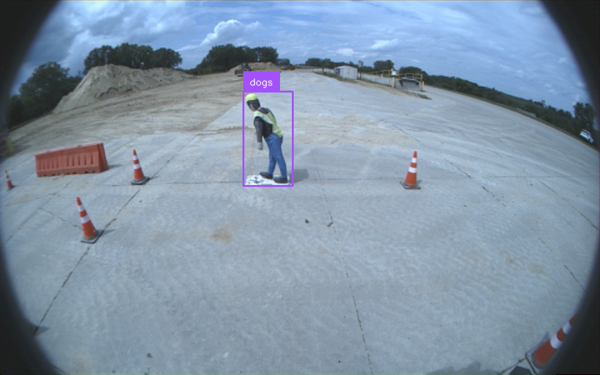

In [61]:
# @title Example caption to phrase grounding inference

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<CAPTION_TO_PHRASE_GROUNDING>"
# text = "<CAPTION_TO_PHRASE_GROUNDING> A man is standing on the road. He is wearing a yellow hard hat. There is a sign next to the man. There are orange and white cones on the ground in front of him. There are some bushes next to the man. A black suv is parked on the side of the road. A building can be seen in the distance behind the suv."
# text = "<CAPTION_TO_PHRASE_GROUNDING> A man in a yellow vest and a yellow helmet is standing on a paved surface. There are orange and white cones around the man. There is a large red container on the ground in front of him."
text = "<CAPTION_TO_PHRASE_GROUNDING> dogs"
inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [59]:
detections

Detections(xyxy=array([[3.89279999e+02, 1.46100006e+02, 4.68959991e+02, 2.99700012e+02],
       [3.89279999e+02, 1.46100006e+02, 4.69919983e+02, 2.99700012e+02],
       [4.79999989e-01, 1.07700005e+02, 9.58559998e+02, 5.99100037e+02],
       [1.17599998e+02, 3.11100006e+02, 1.67519989e+02, 3.94500031e+02],
       [6.39839966e+02, 2.37900009e+02, 6.80159973e+02, 3.08700012e+02],
       [2.05919998e+02, 2.34300003e+02, 2.45279999e+02, 3.01500000e+02],
       [4.31999969e+00, 2.67300018e+02, 3.11999989e+01, 3.09900024e+02],
       [5.42399979e+01, 2.24100006e+02, 1.80000000e+02, 2.87700012e+02],
       [5.32320007e+02, 1.01700005e+02, 5.80320007e+02, 1.32300003e+02],
       [4.42079987e+02, 9.03000031e+01, 4.73759979e+02, 1.15500008e+02],
       [5.32320007e+02, 1.01700005e+02, 5.79359985e+02, 1.32300003e+02],
       [3.72959991e+02, 9.69000015e+01, 4.10399994e+02, 1.28100006e+02],
       [3.89279999e+02, 1.46100006e+02, 4.68000000e+02, 2.99700012e+02],
       [4.79999989e-01, 3.00000012e

## Fine-tune Florence-2 on custom dataset

### Download dataset from Roboflow Universe

In [ ]:
ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("roboflow-jvuqo").project("poker-cards-fmjio")
version = project.version(4)
dataset = version.download("florence2-od")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to poker-cards-4 in florence2-od:: 100%|██████████| 907/907 [00:00<00:00, 5523.97it/s]


In [ ]:
!head -n 5 {dataset.location}/train/annotations.jsonl

{"image":"IMG_20220316_172418_jpg.rf.e3cb4a86dc0247e71e3697aa3e9db923.jpg","prefix":"<OD>","suffix":"9 of clubs<loc_138><loc_100><loc_470><loc_448>10 of clubs<loc_388><loc_145><loc_670><loc_453>jack  of clubs<loc_566><loc_166><loc_823><loc_432>queen of clubs<loc_365><loc_465><loc_765><loc_999>king of clubs<loc_601><loc_440><loc_949><loc_873>"}
{"image":"IMG_20220316_171515_jpg.rf.e3b1932bb375b3b3912027647586daa8.jpg","prefix":"<OD>","suffix":"5 of clubs<loc_554><loc_2><loc_763><loc_467>6 of clubs<loc_399><loc_79><loc_555><loc_466>7 of clubs<loc_363><loc_484><loc_552><loc_905>8 of clubs<loc_535><loc_449><loc_757><loc_971>"}
{"image":"IMG_20220316_165139_jpg.rf.e30257ec169a2bfdfecb693211d37250.jpg","prefix":"<OD>","suffix":"9 of diamonds<loc_596><loc_535><loc_859><loc_982>jack of diamonds<loc_211><loc_546><loc_411><loc_880>queen of diamonds<loc_430><loc_34><loc_692><loc_518>king of diamonds<loc_223><loc_96><loc_451><loc_523>10 of diamonds<loc_387><loc_542><loc_604><loc_925>"}
{"image":"I

In [ ]:
# @title Define `DetectionsDataset` class

class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

In [ ]:
# @title Initiate `DetectionsDataset` and `DataLoader` for train and validation subsets

BATCH_SIZE = 6
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/train/annotations.jsonl",
    image_directory_path = f"{dataset.location}/train/"
)
val_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/valid/annotations.jsonl",
    image_directory_path = f"{dataset.location}/valid/"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [ ]:
# @title Setup LoRA Florence-2 model

config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 1,929,928 || all params: 272,733,896 || trainable%: 0.7076


In [ ]:
torch.cuda.empty_cache()


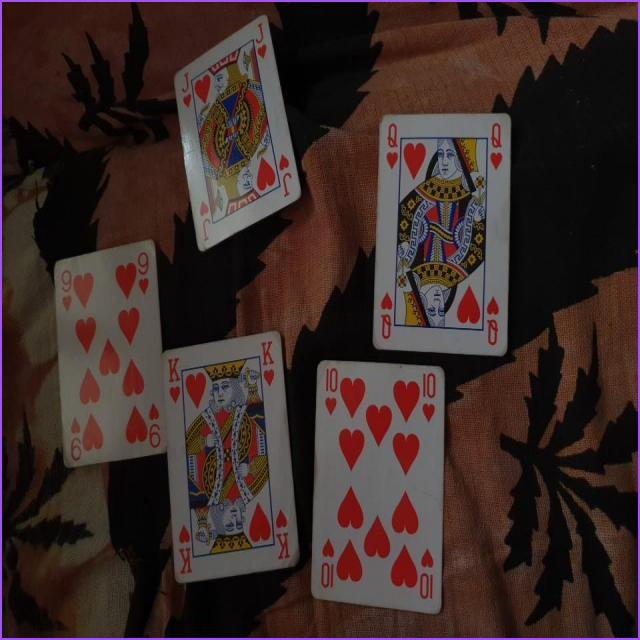
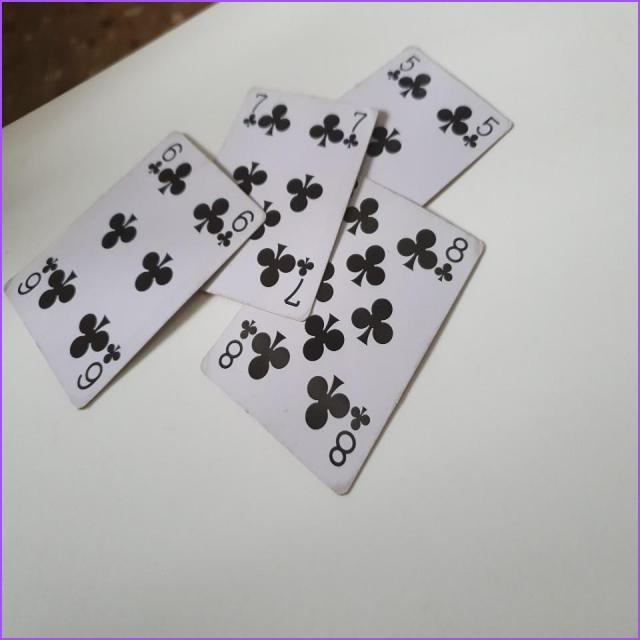
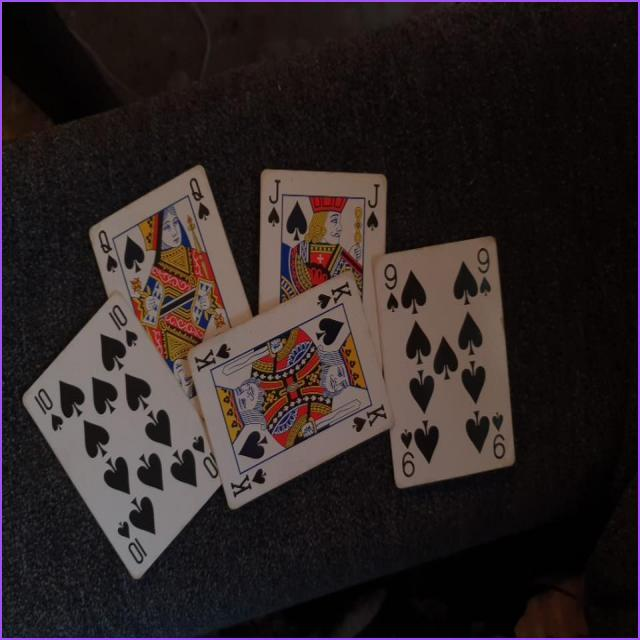
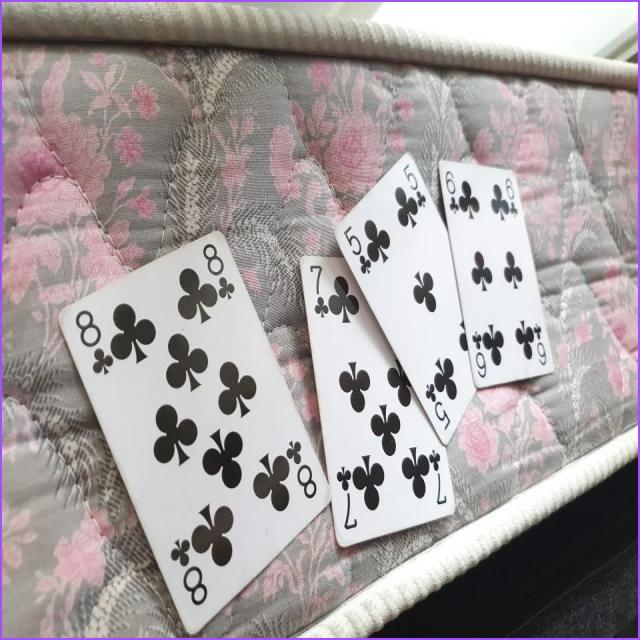

In [ ]:
# @title Run inference with pre-trained Florence-2 model on validation dataset

def render_inline(image: Image.Image, resize=(128, 128)):
    """Convert image into inline html."""
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image: Image.Image, response):
    try:
        detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
        image = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
        image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)
    except:
        print('failed to redner model response')
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:256px; height:256px;" src="{render_inline(image, resize=(128, 128))}" />
    <p style="width:512px; margin:10px; font-size:small;">{html.escape(json.dumps(response))}</p>
</div>
"""


def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        html_out += render_example(image, answer)

    display(HTML(html_out))

render_inference_results(peft_model, val_dataset, 4)

## Fine-tune Florence-2 on custom object detection dataset

In [ ]:
# @title Define train loop

def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    render_inference_results(peft_model, val_loader.dataset, 6)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            render_inference_results(peft_model, val_loader.dataset, 6)

        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)


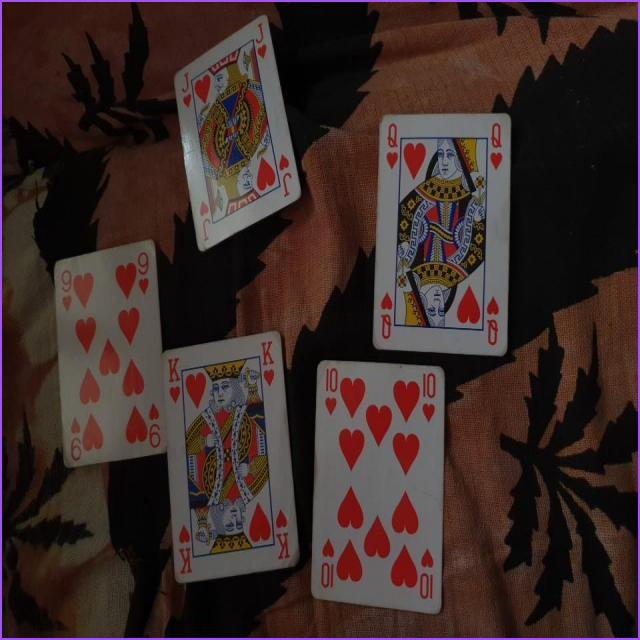
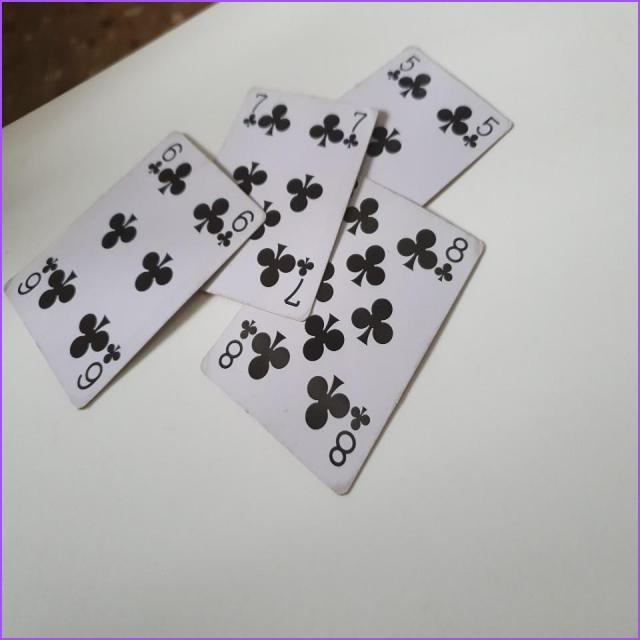
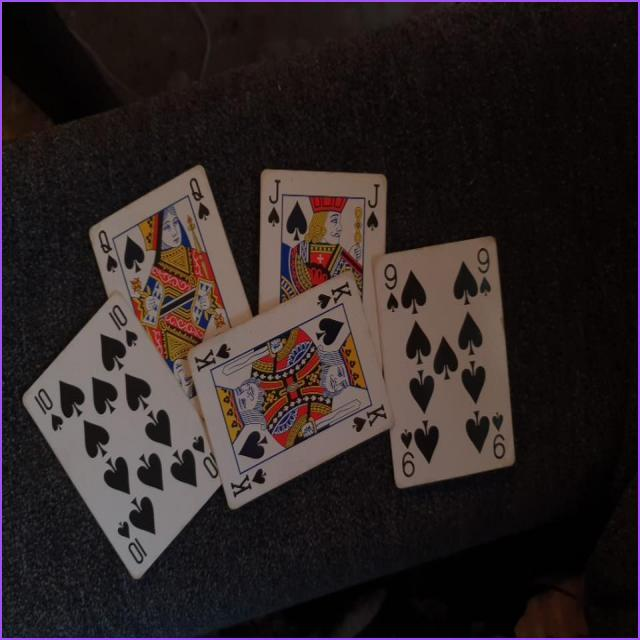
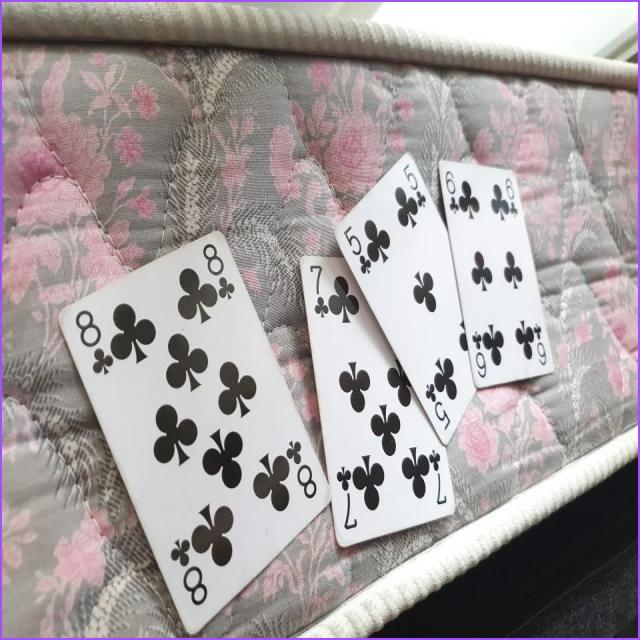
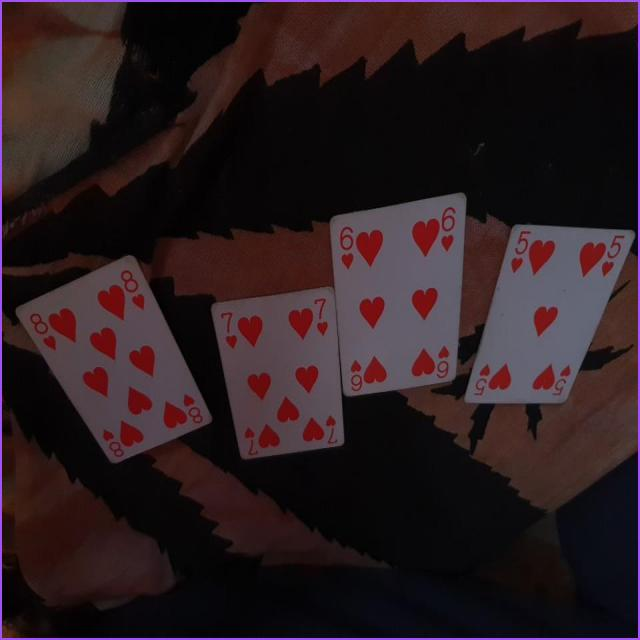
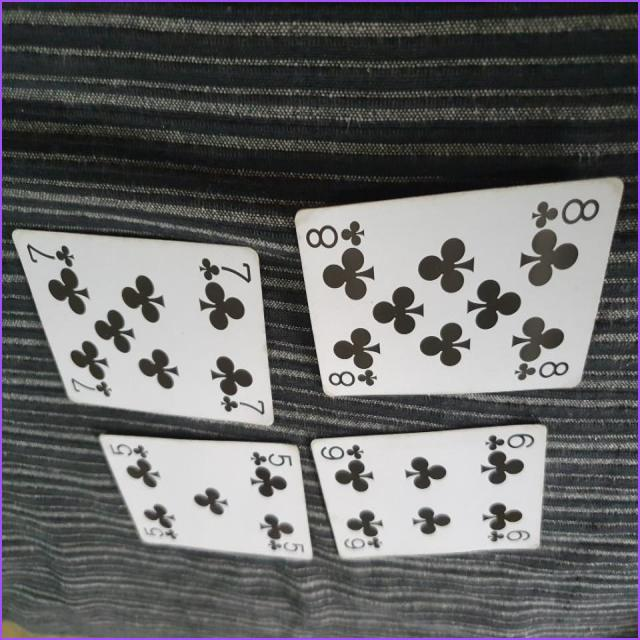

Training Epoch 1/10: 100%|██████████| 136/136 [03:30<00:00,  1.55s/it]


Average Training Loss: 4.896057416411007


Validation Epoch 1/10: 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


Average Validation Loss: 3.4786863029003143



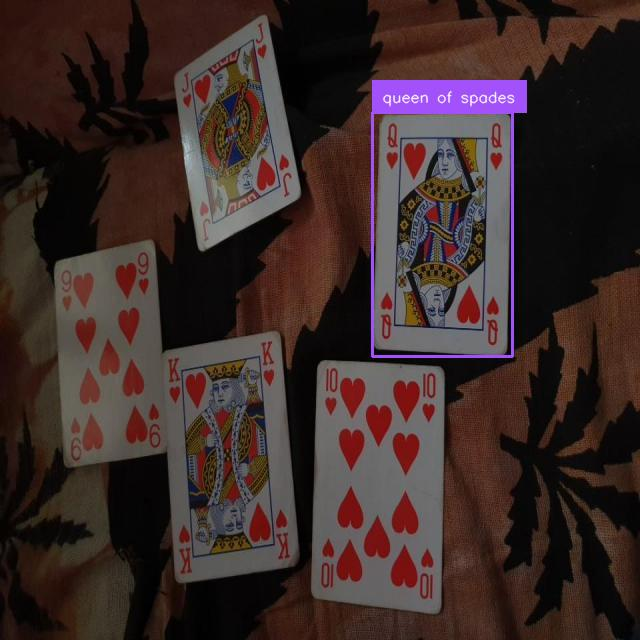
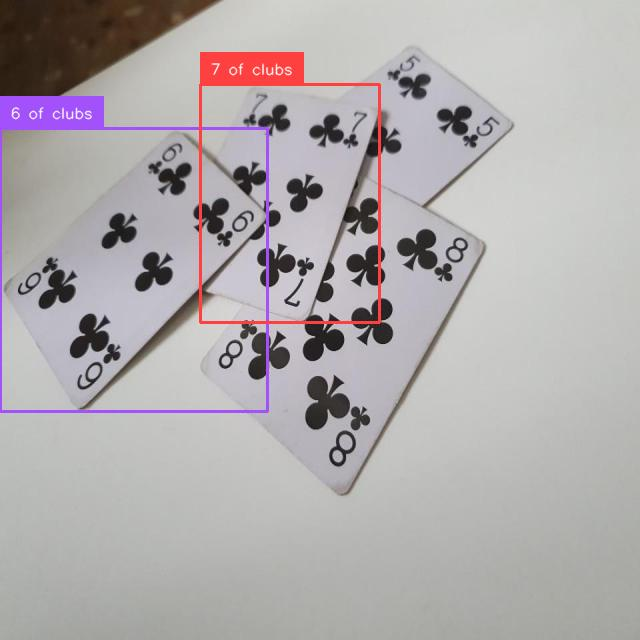
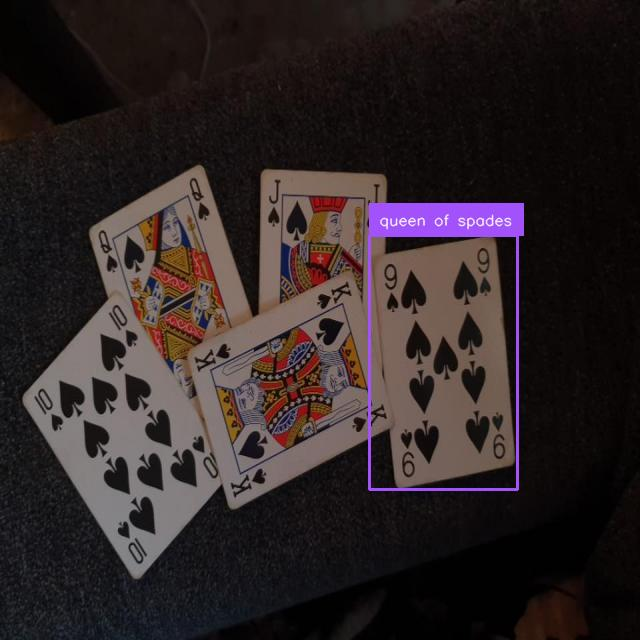
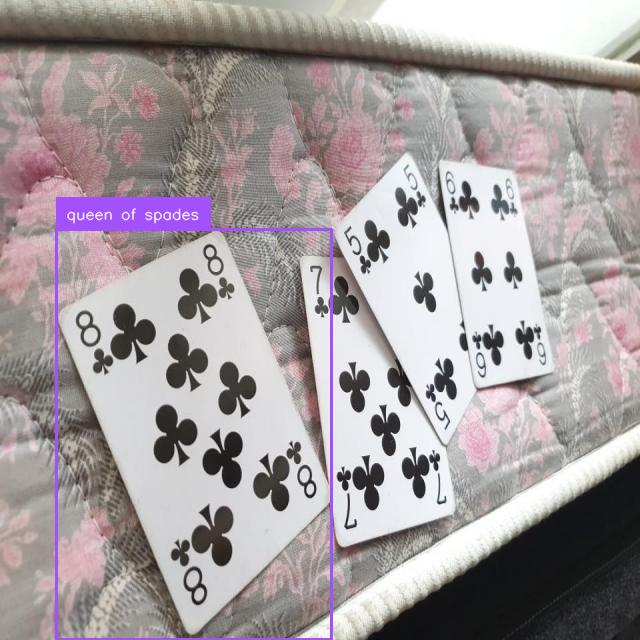
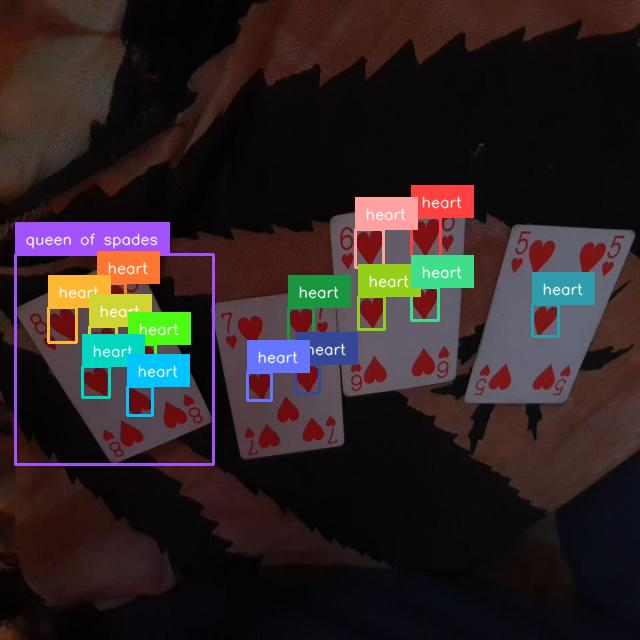
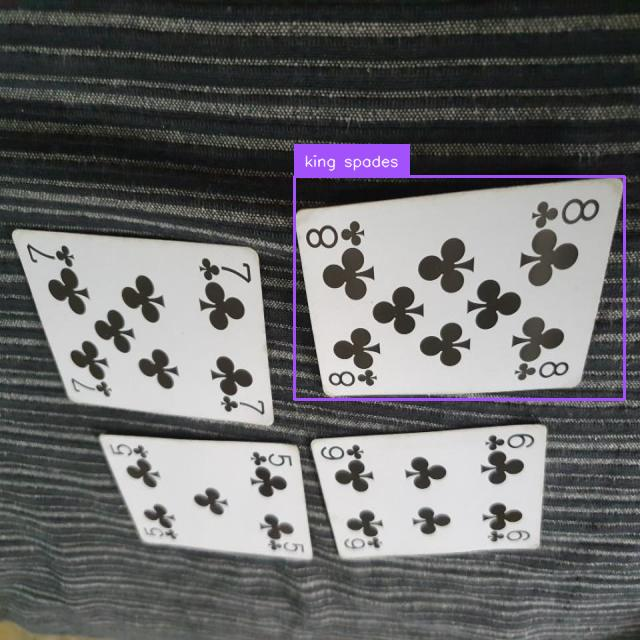

Training Epoch 2/10: 100%|██████████| 136/136 [03:33<00:00,  1.57s/it]


Average Training Loss: 3.440452910521451


Validation Epoch 2/10: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Average Validation Loss: 2.6039147675037384



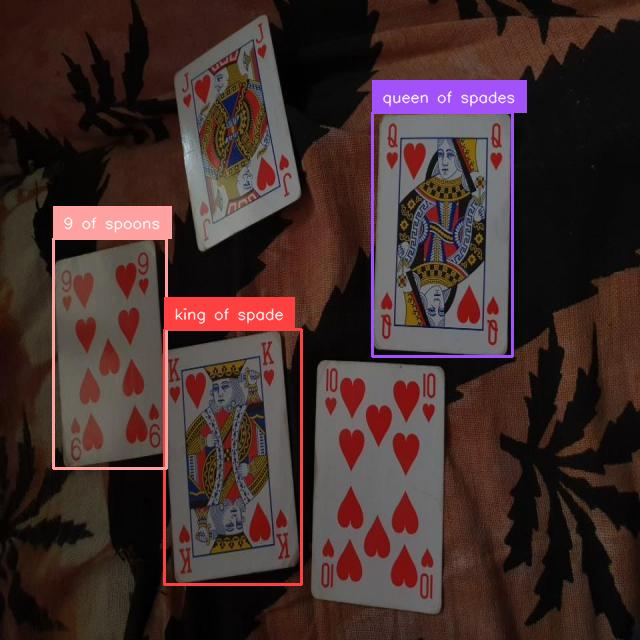
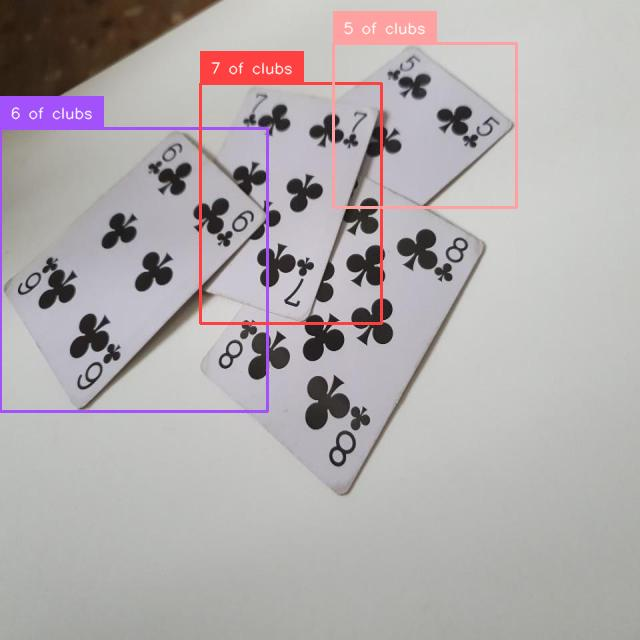
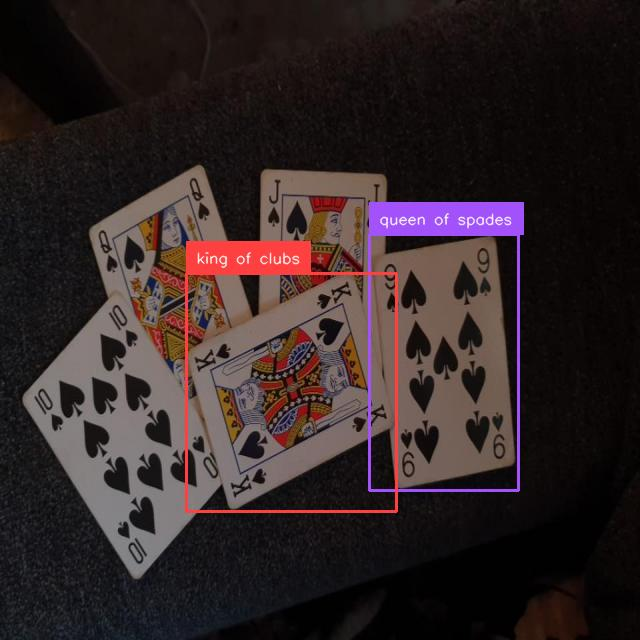
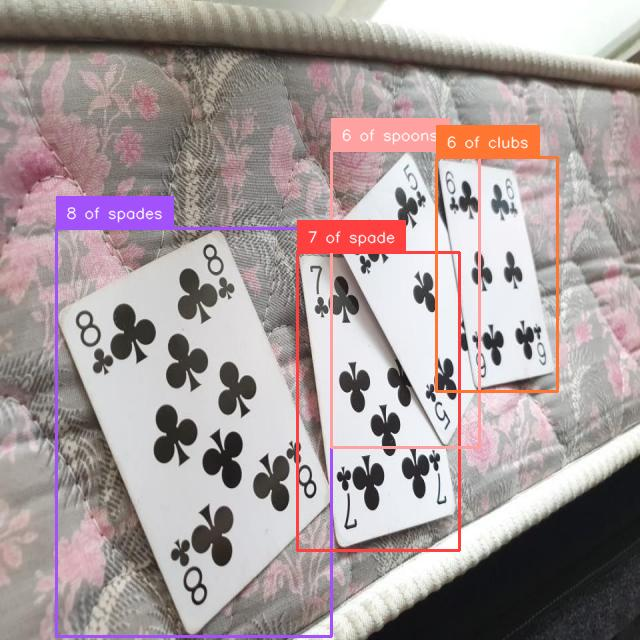
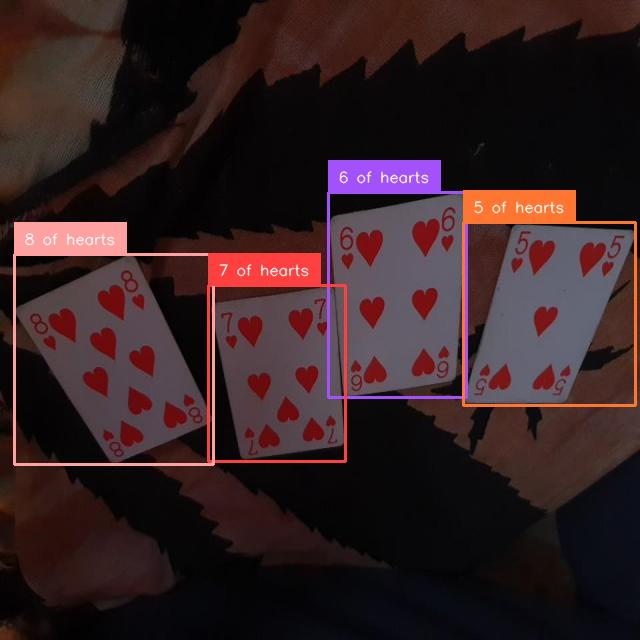
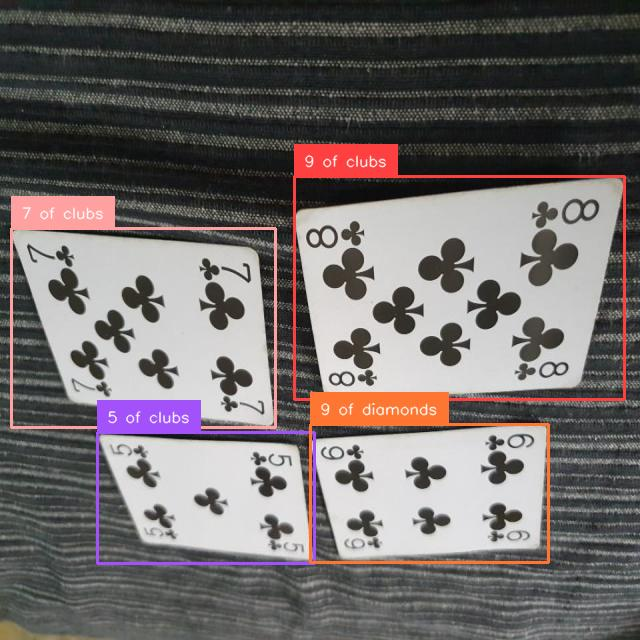

Training Epoch 3/10: 100%|██████████| 136/136 [03:34<00:00,  1.58s/it]


Average Training Loss: 2.5235286013168445


Validation Epoch 3/10: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Average Validation Loss: 1.7801695317029953



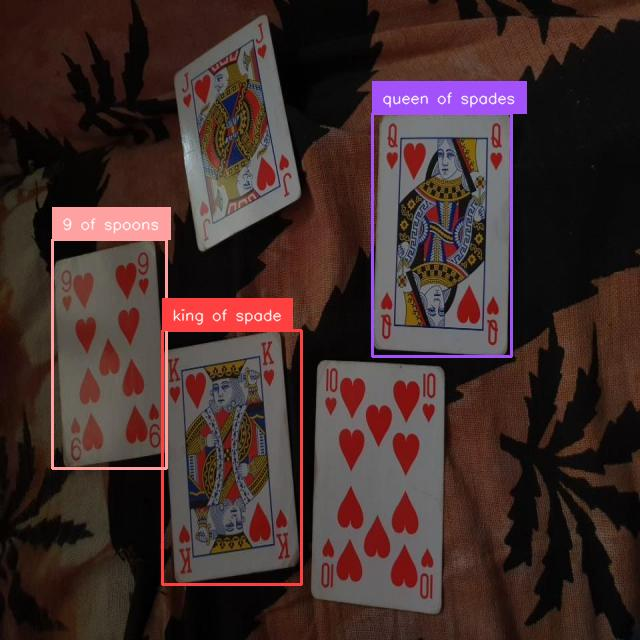
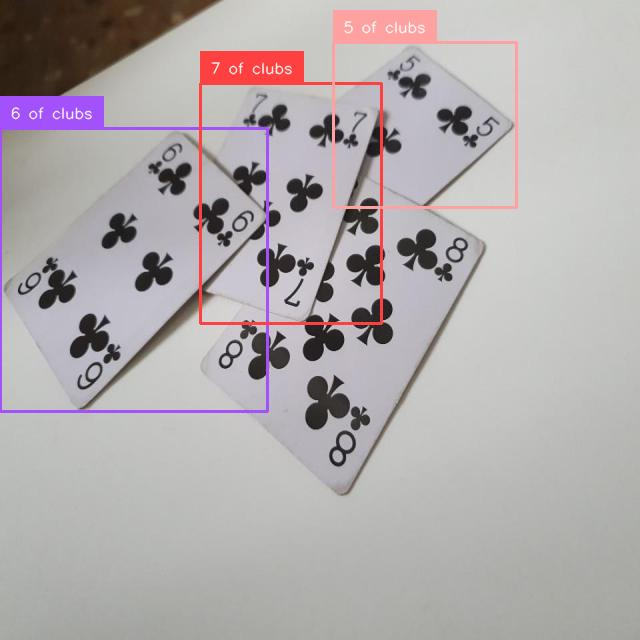
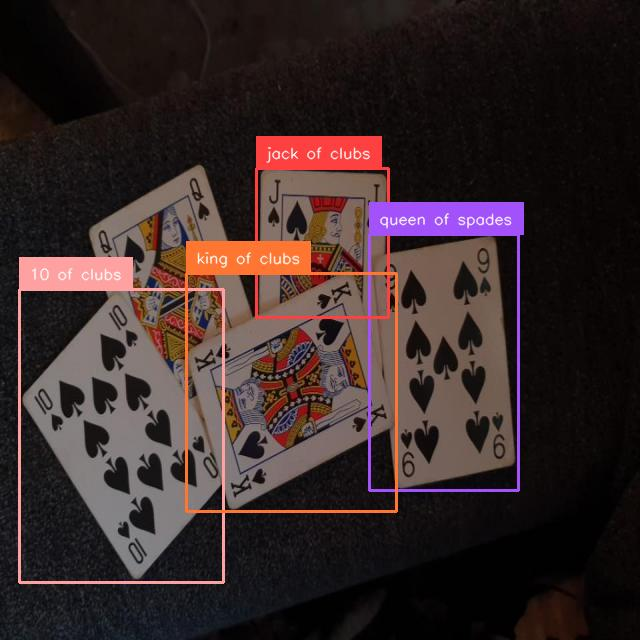
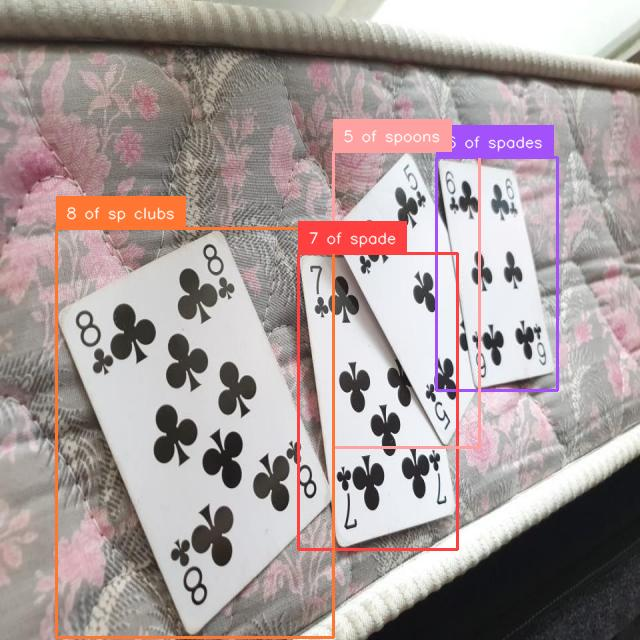
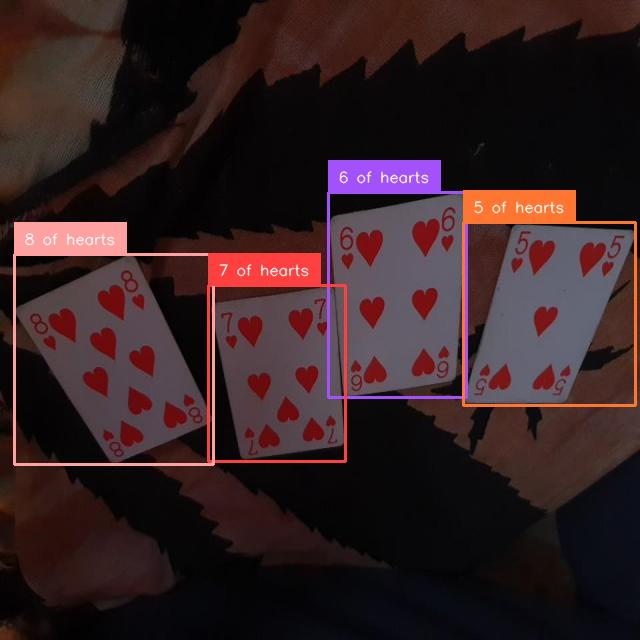
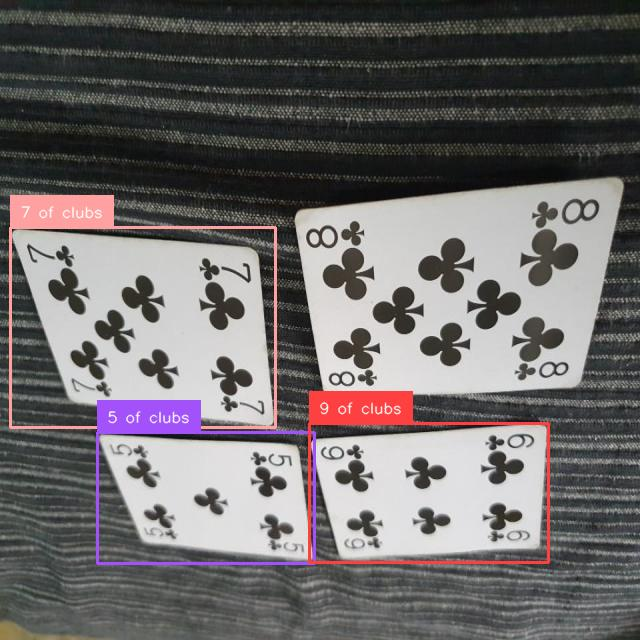

Training Epoch 4/10: 100%|██████████| 136/136 [03:35<00:00,  1.58s/it]


Average Training Loss: 1.8527188660467373


Validation Epoch 4/10: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Average Validation Loss: 1.6526391357183456



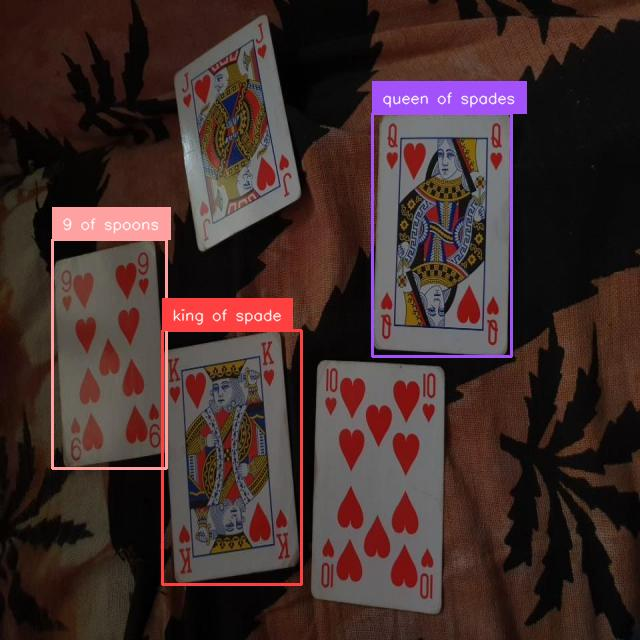
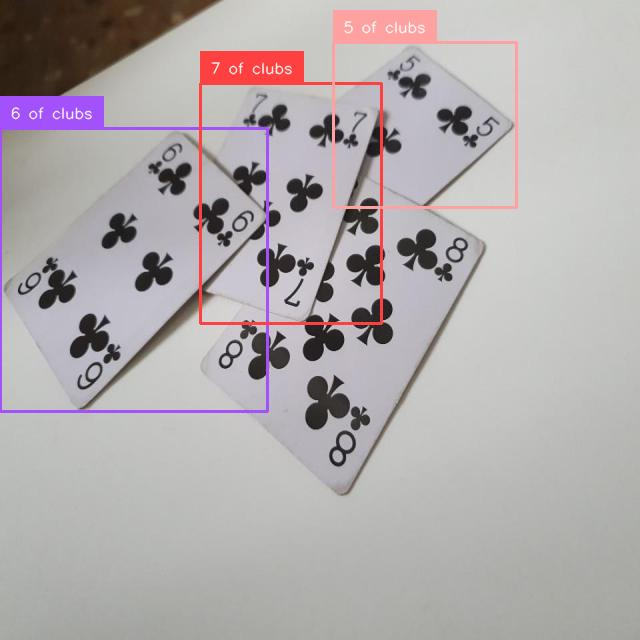
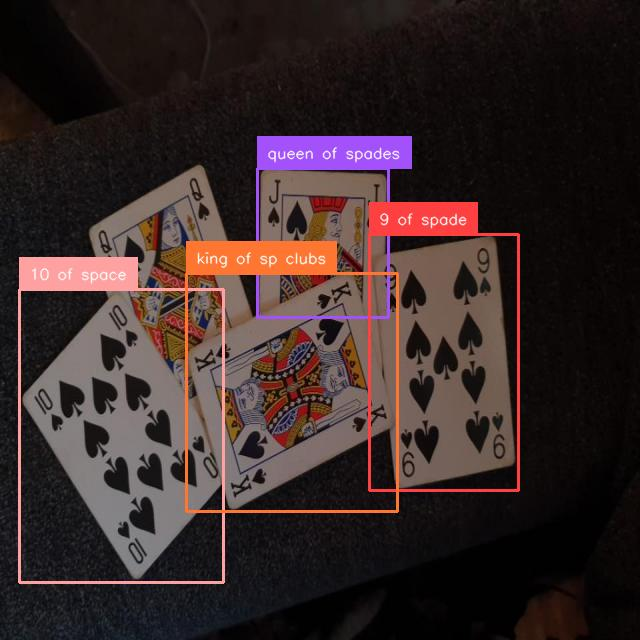
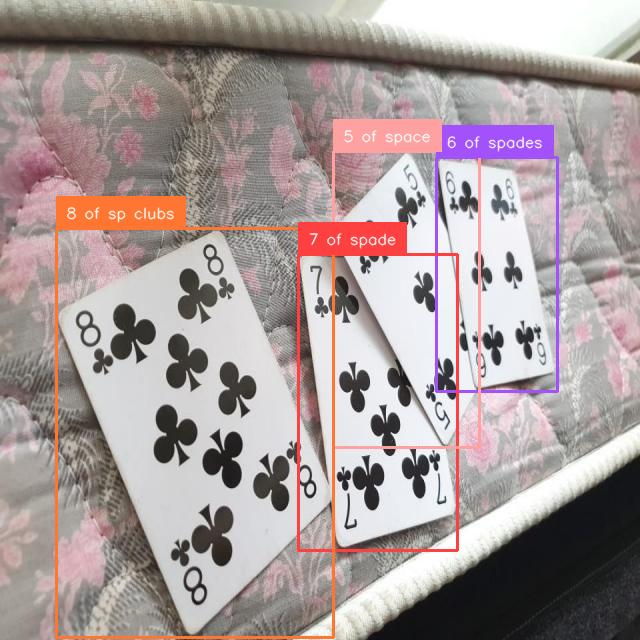
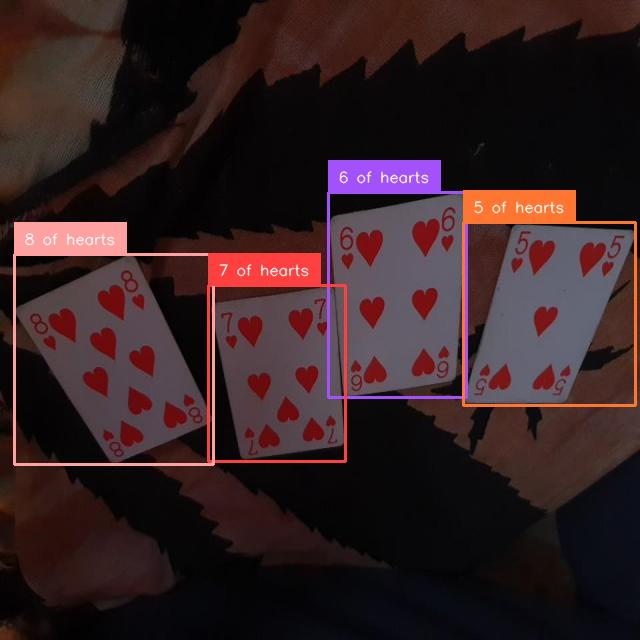
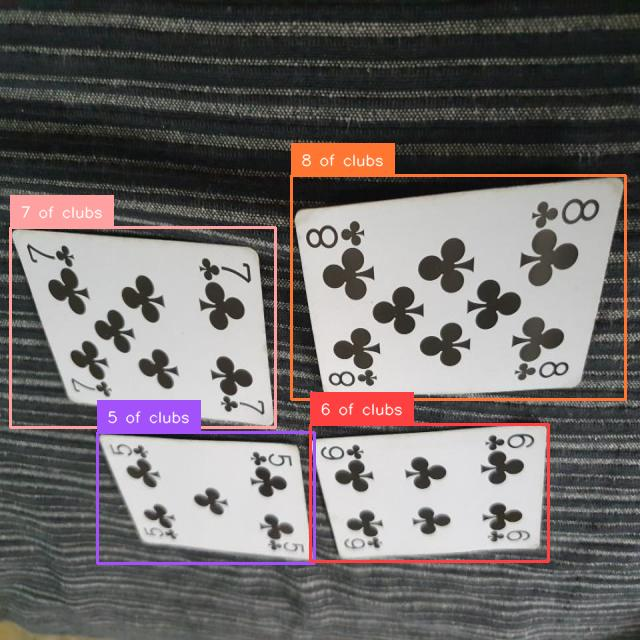

Training Epoch 5/10: 100%|██████████| 136/136 [03:35<00:00,  1.59s/it]


Average Training Loss: 1.6888017277507221


Validation Epoch 5/10: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Average Validation Loss: 1.6089141070842743



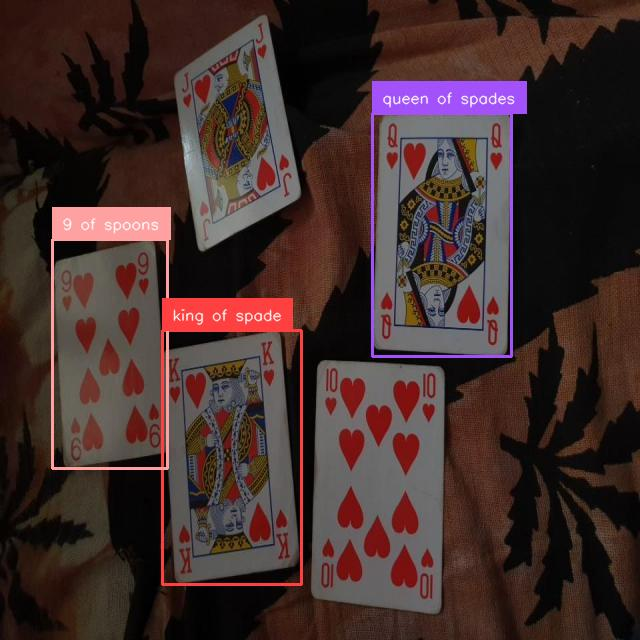
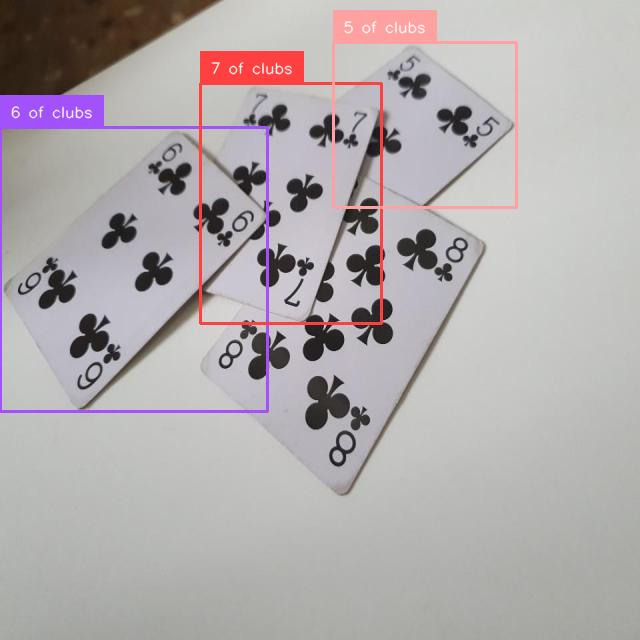
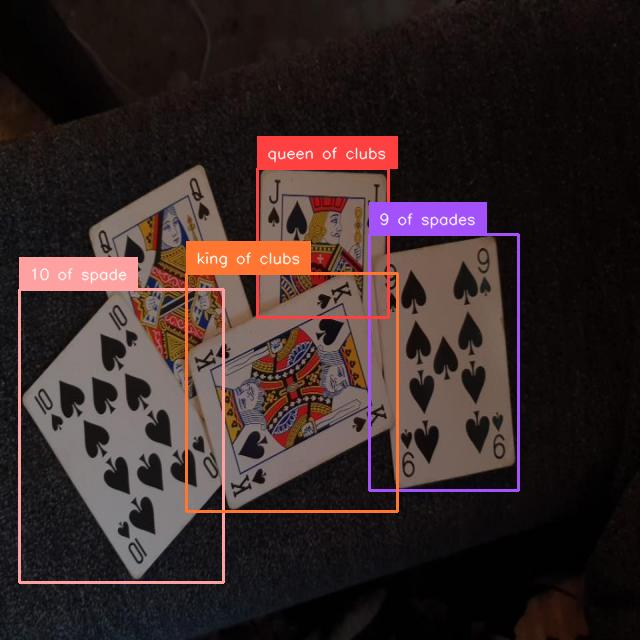
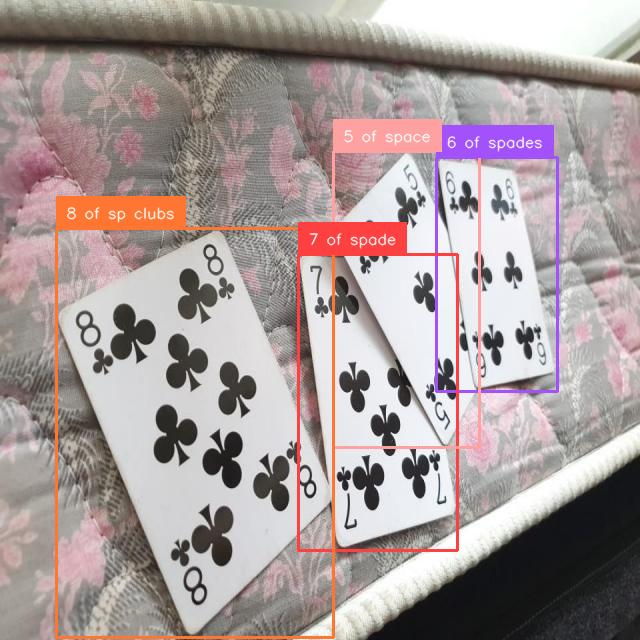
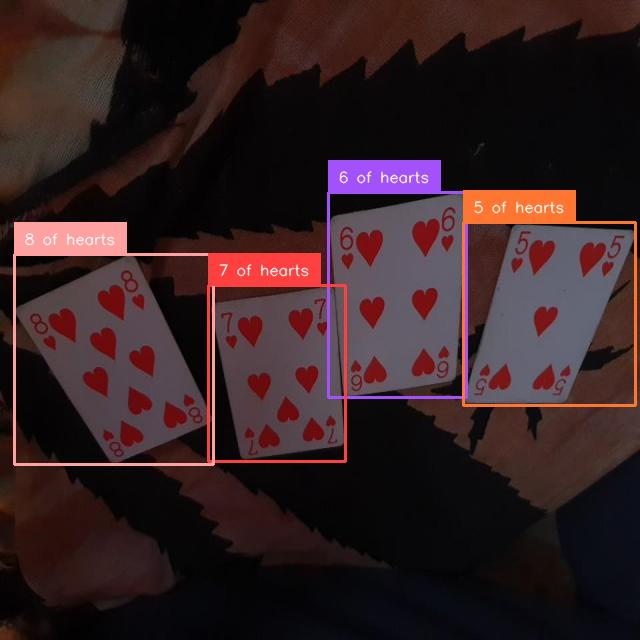
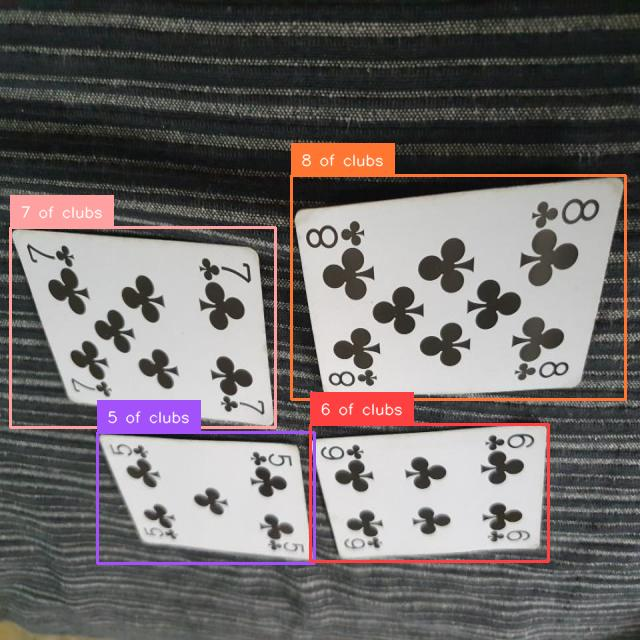

Training Epoch 6/10: 100%|██████████| 136/136 [03:35<00:00,  1.58s/it]


Average Training Loss: 1.6428528463139254


Validation Epoch 6/10: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Average Validation Loss: 1.5795495808124542



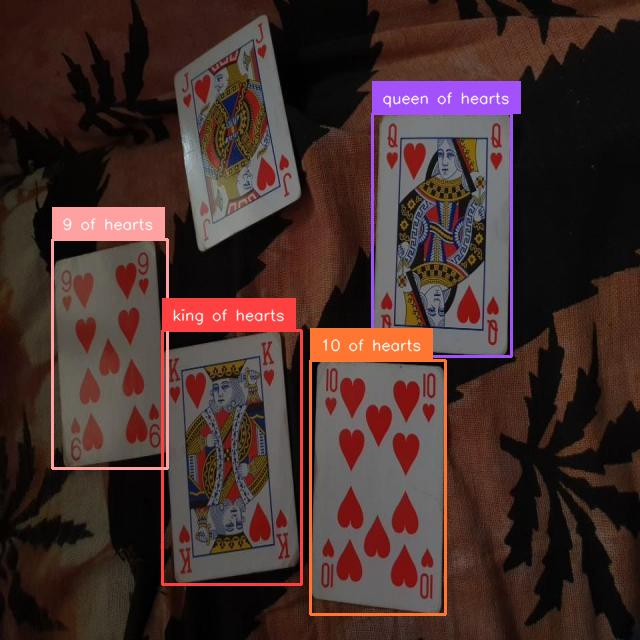
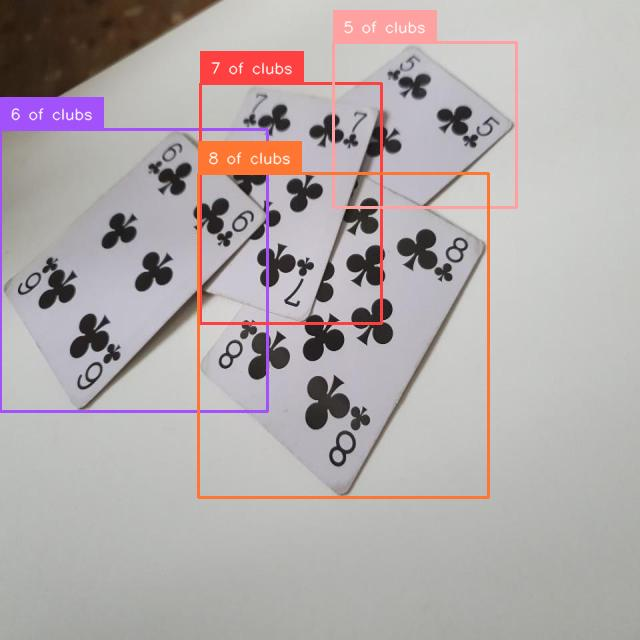
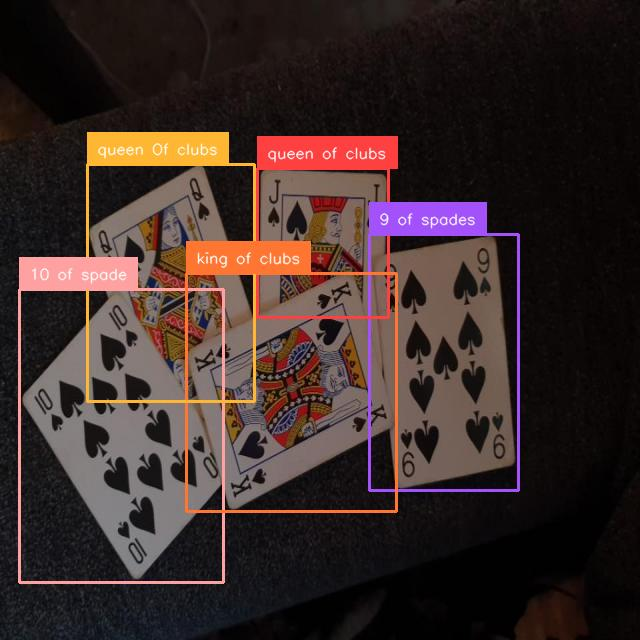
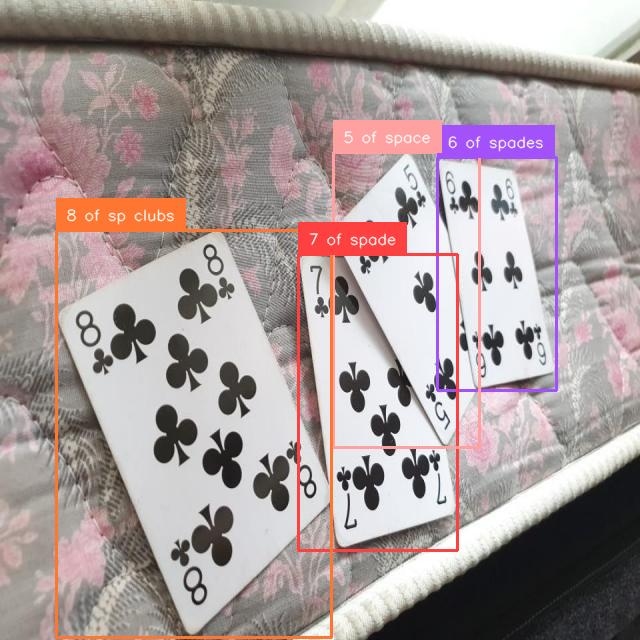
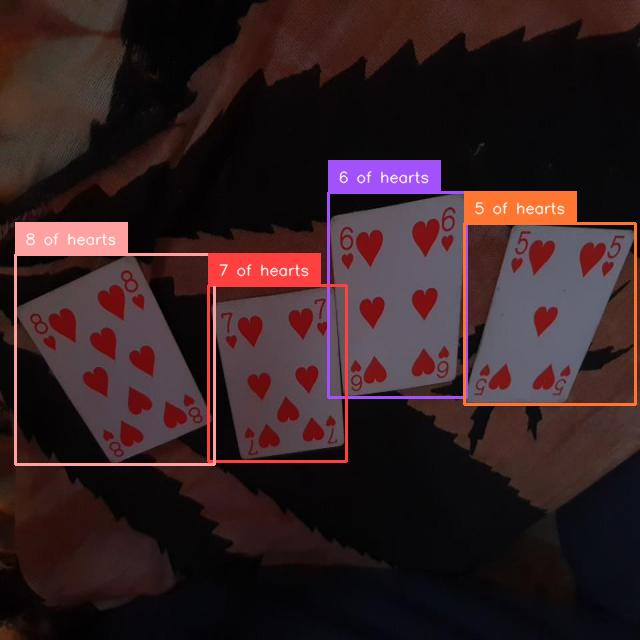
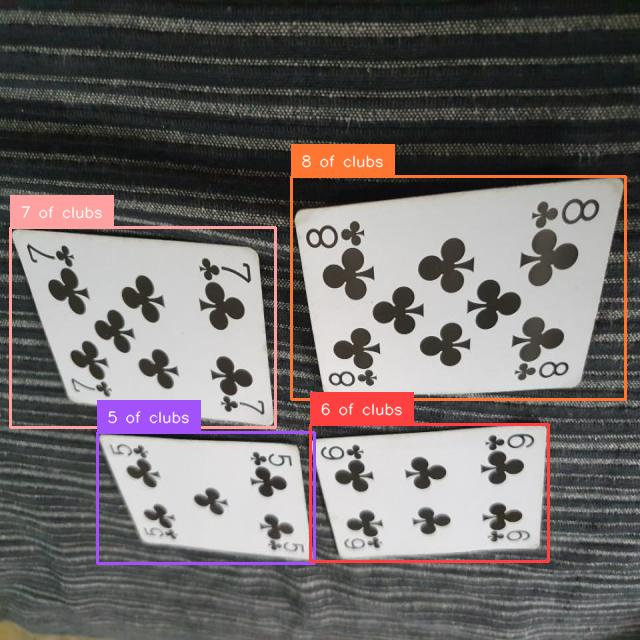

Training Epoch 7/10: 100%|██████████| 136/136 [03:34<00:00,  1.58s/it]


Average Training Loss: 1.606858080800842


Validation Epoch 7/10: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Average Validation Loss: 1.5592510253190994



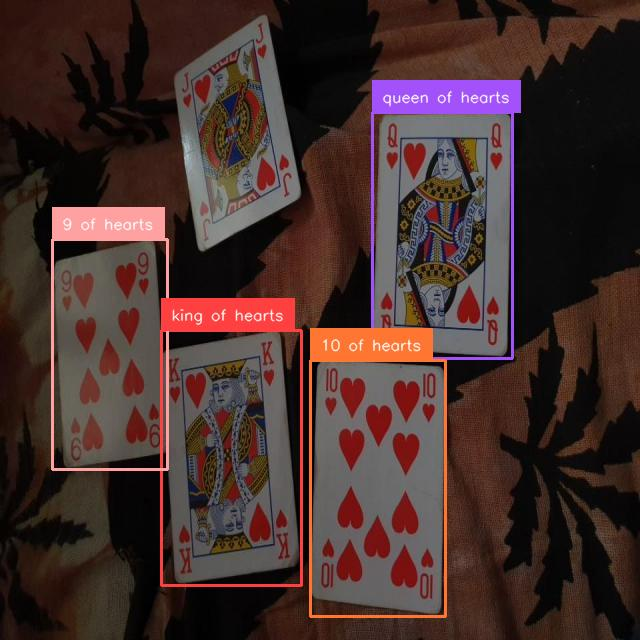
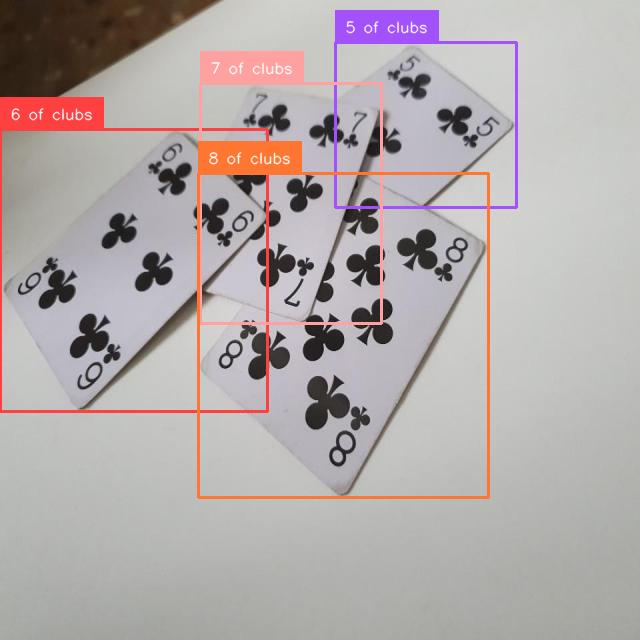
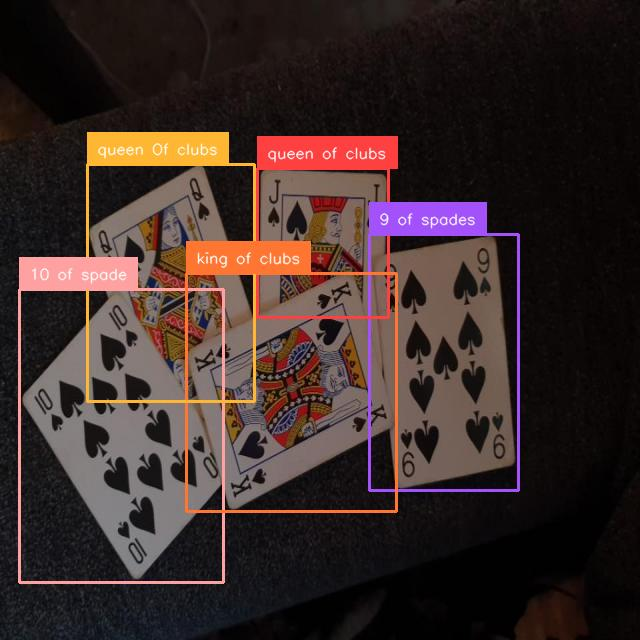
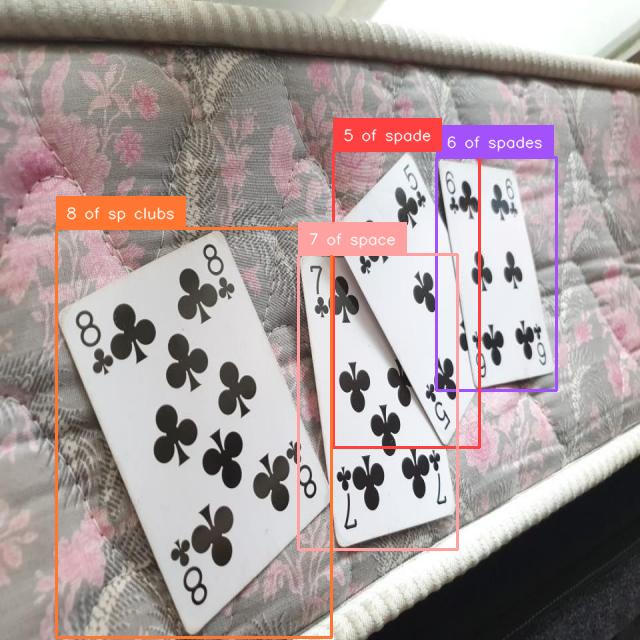
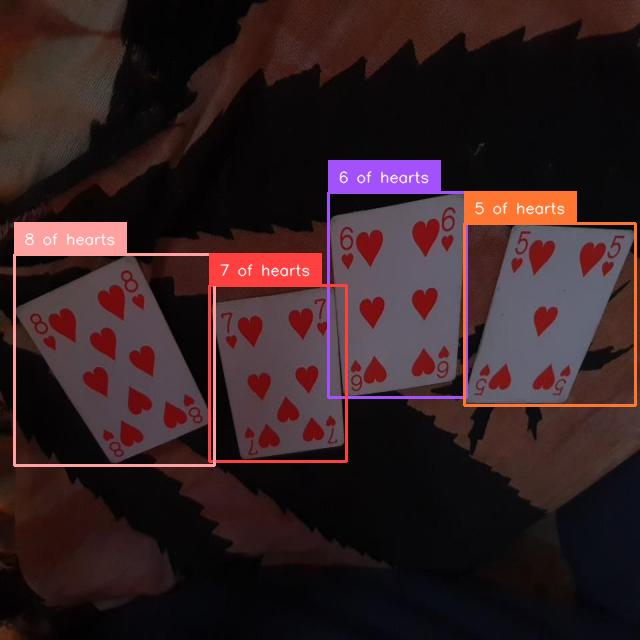
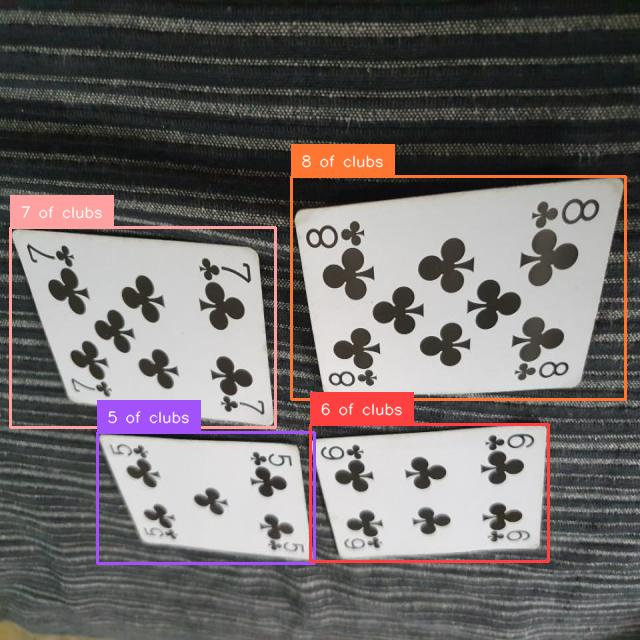

Training Epoch 8/10: 100%|██████████| 136/136 [03:35<00:00,  1.58s/it]


Average Training Loss: 1.5927585898076786


Validation Epoch 8/10: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Average Validation Loss: 1.545723870396614



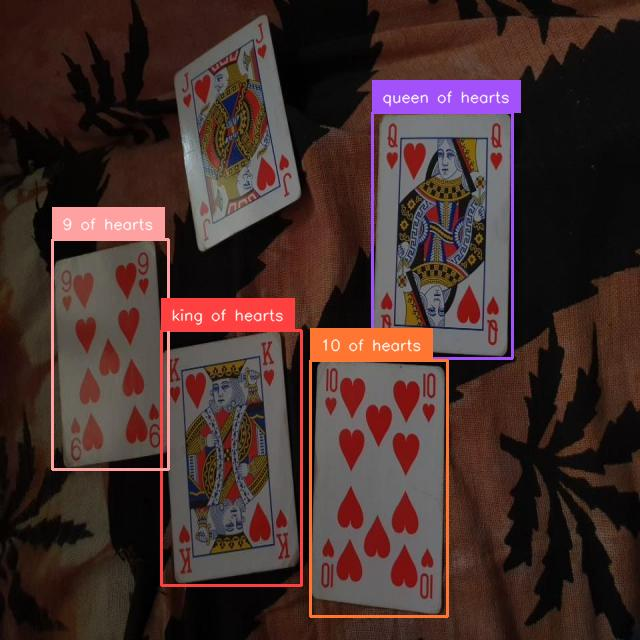
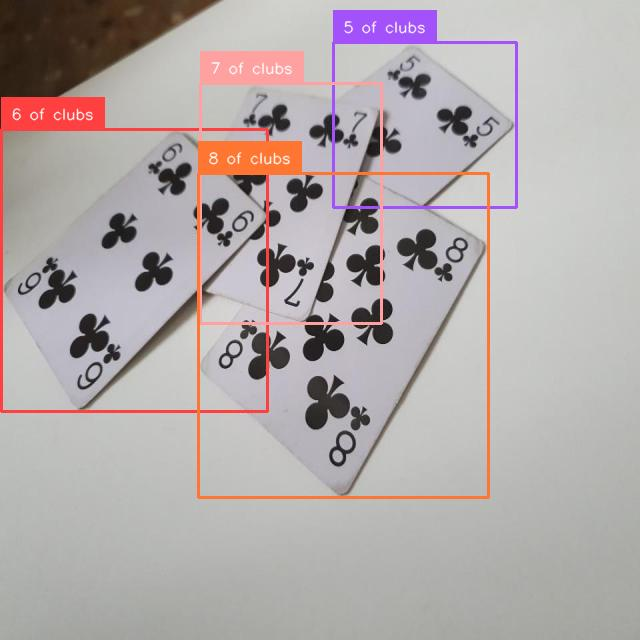
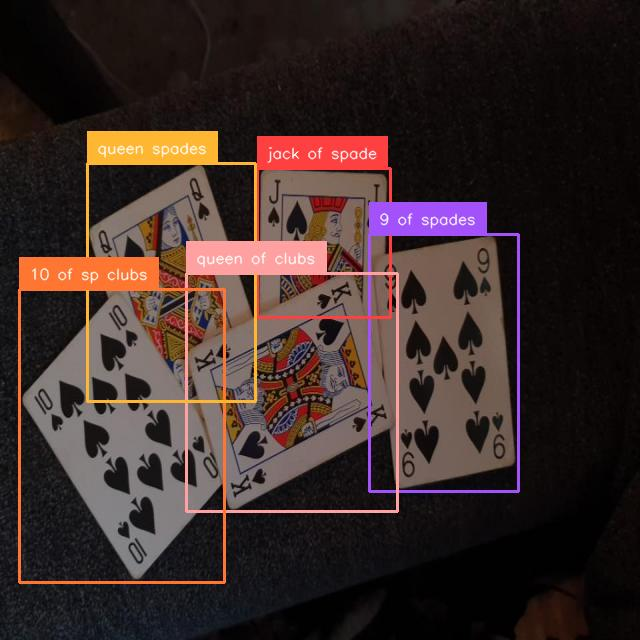
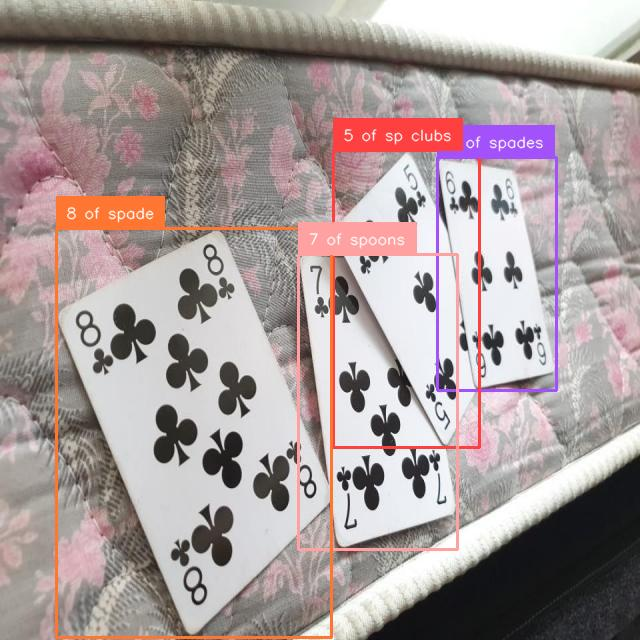
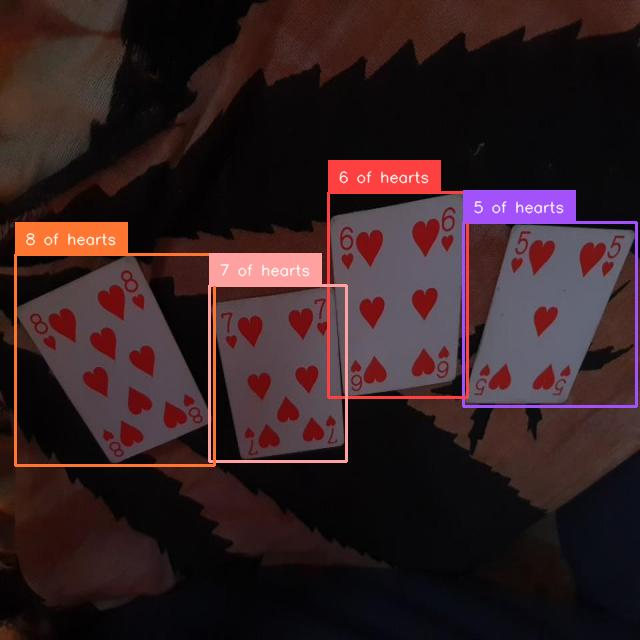
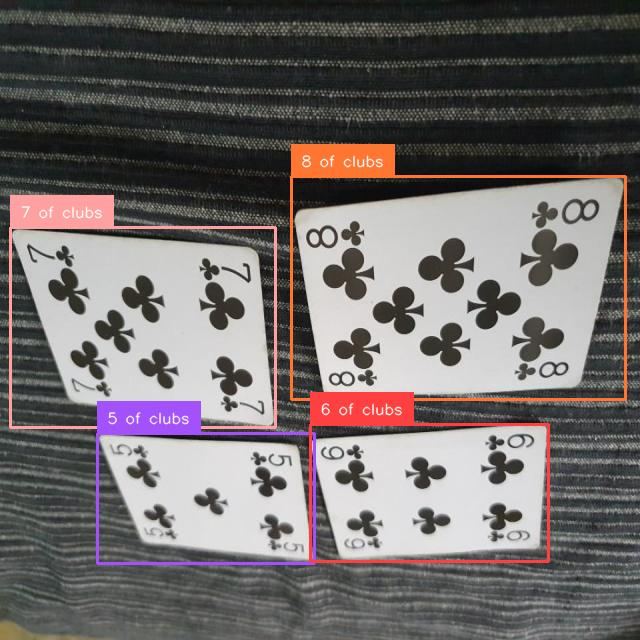

Training Epoch 9/10: 100%|██████████| 136/136 [03:35<00:00,  1.58s/it]


Average Training Loss: 1.5652842425248201


Validation Epoch 9/10: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Average Validation Loss: 1.5385789722204208



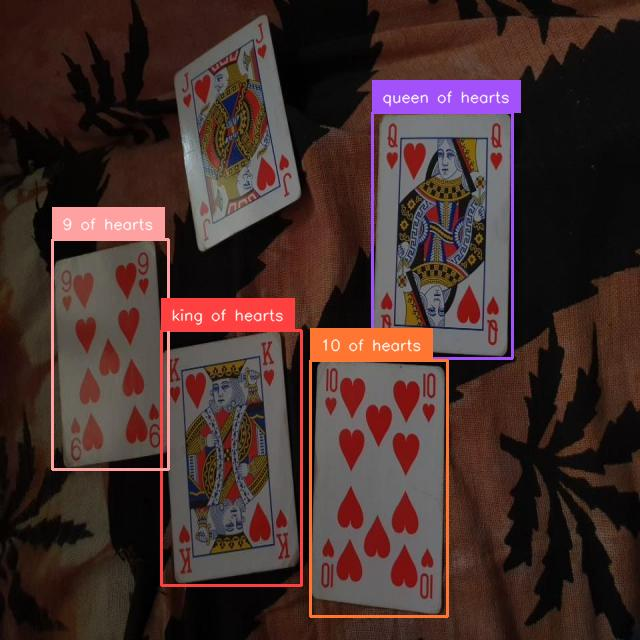
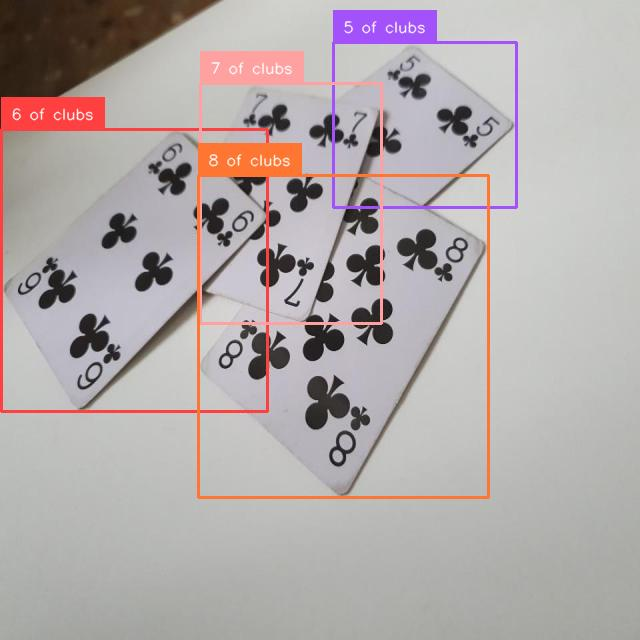
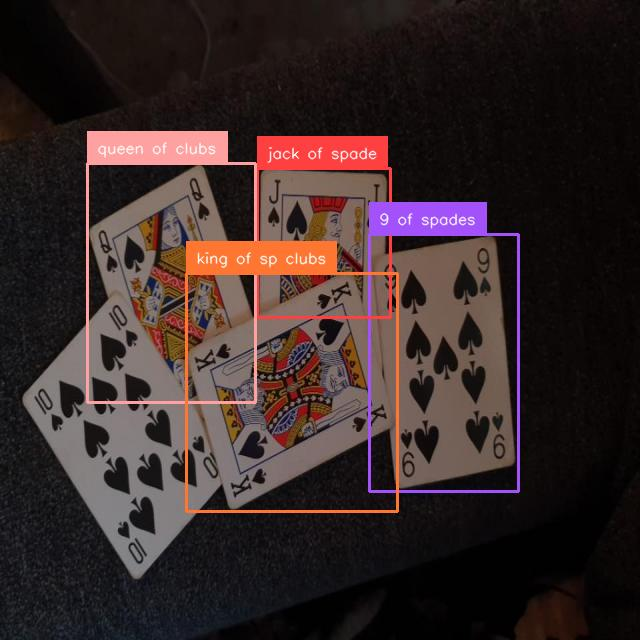
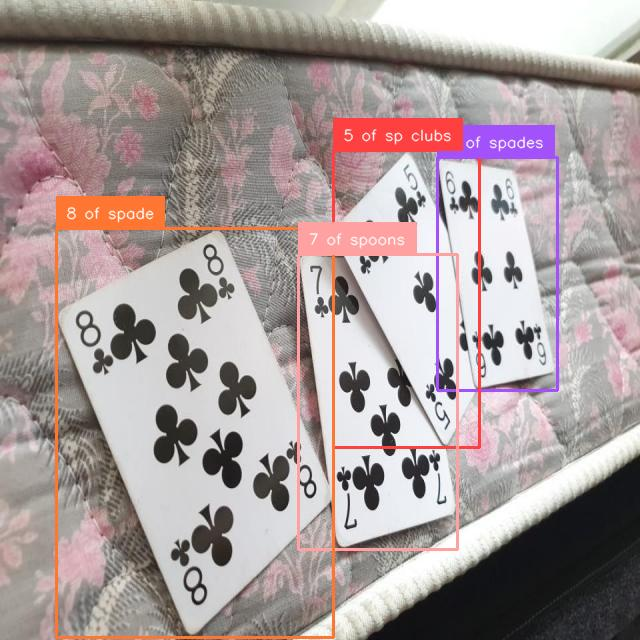
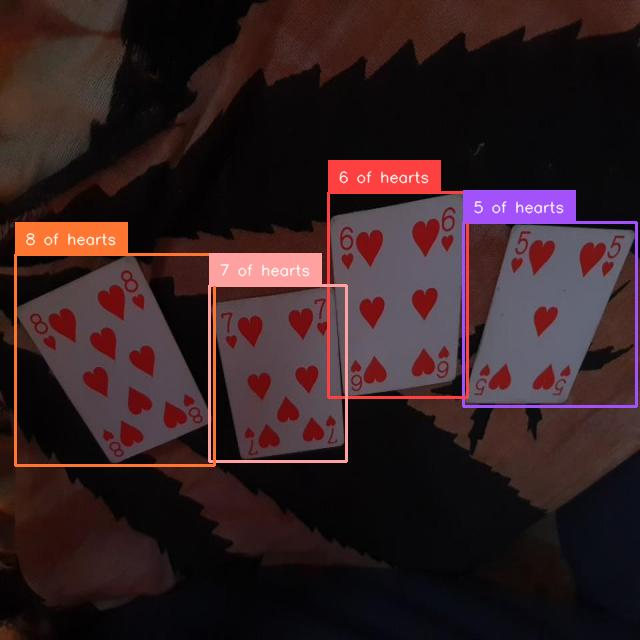
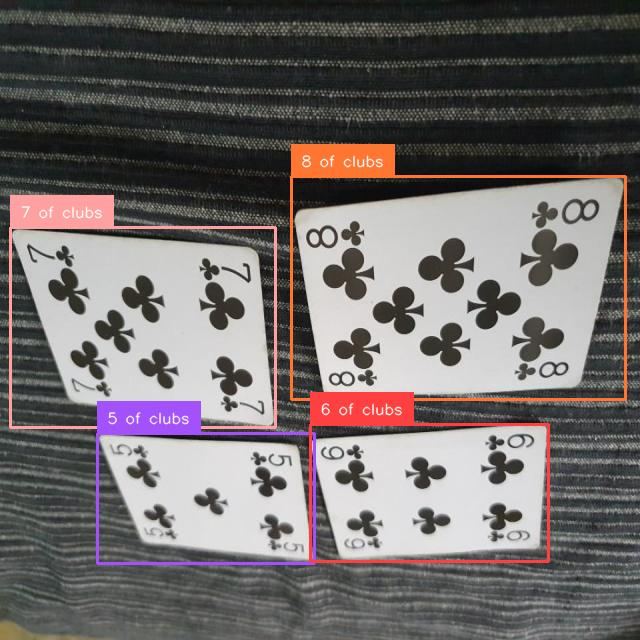

Training Epoch 10/10: 100%|██████████| 136/136 [03:35<00:00,  1.58s/it]


Average Training Loss: 1.5636658913948958


Validation Epoch 10/10: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Average Validation Loss: 1.5356440246105194



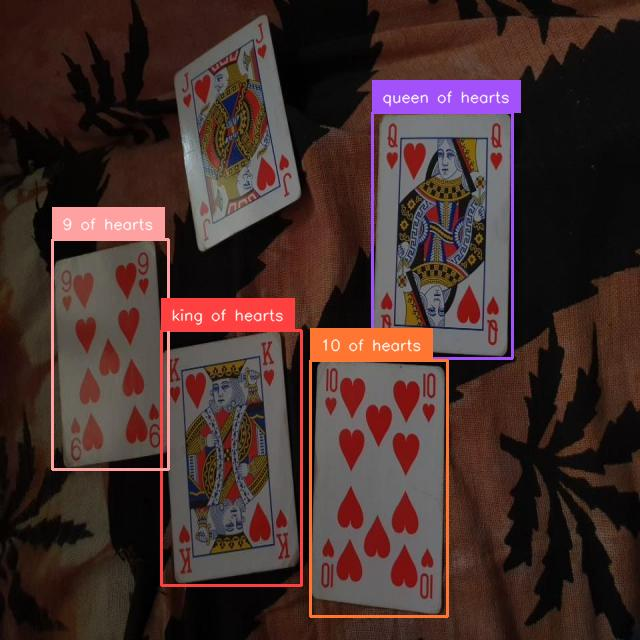
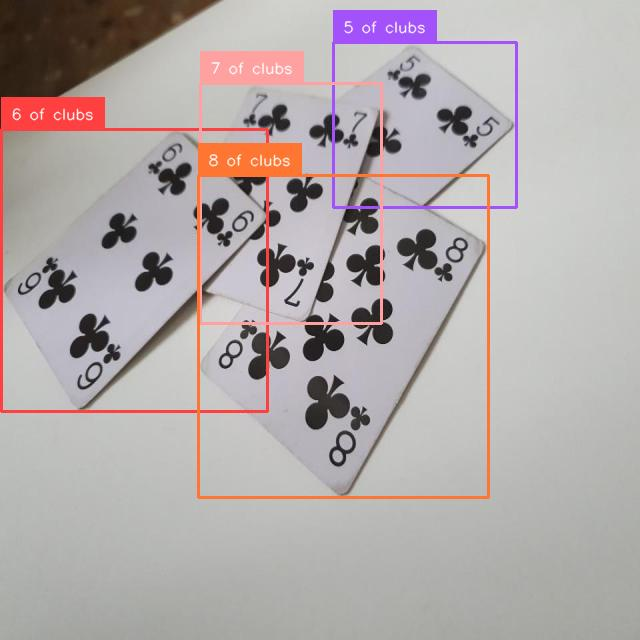
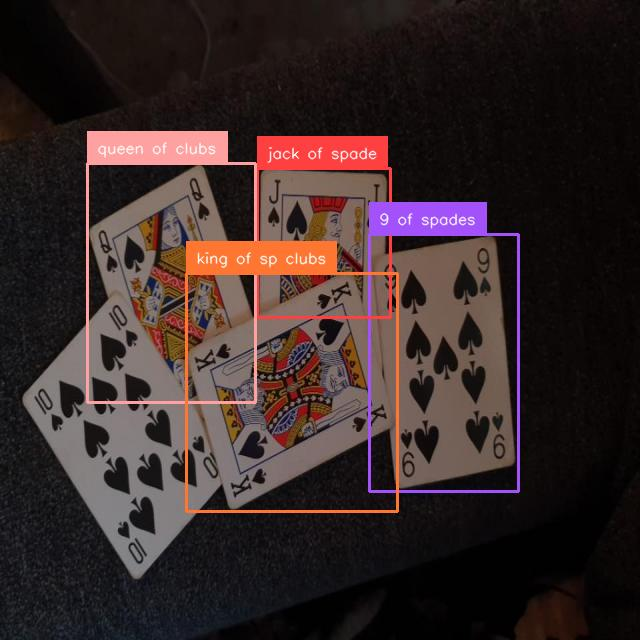
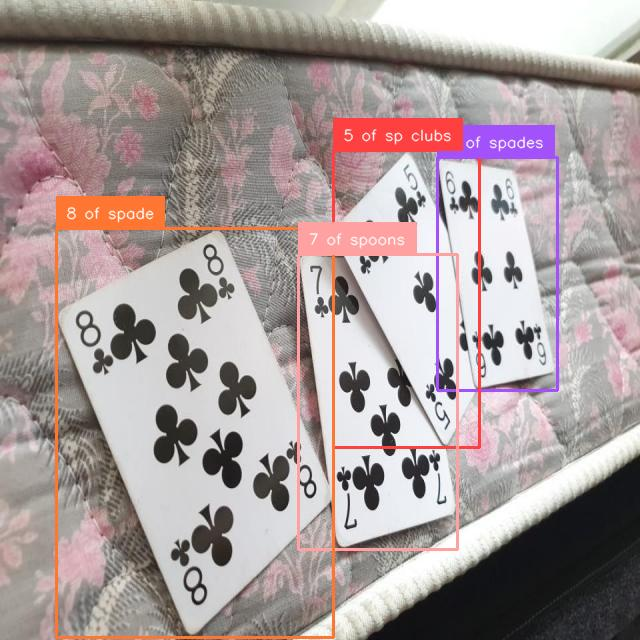
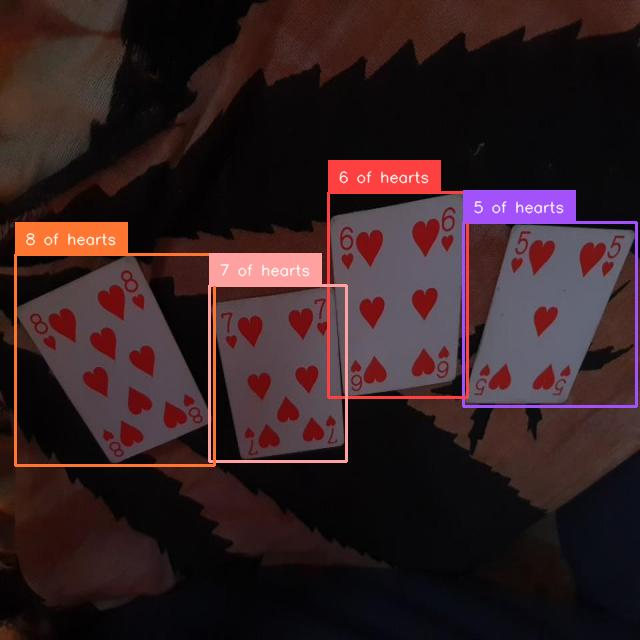
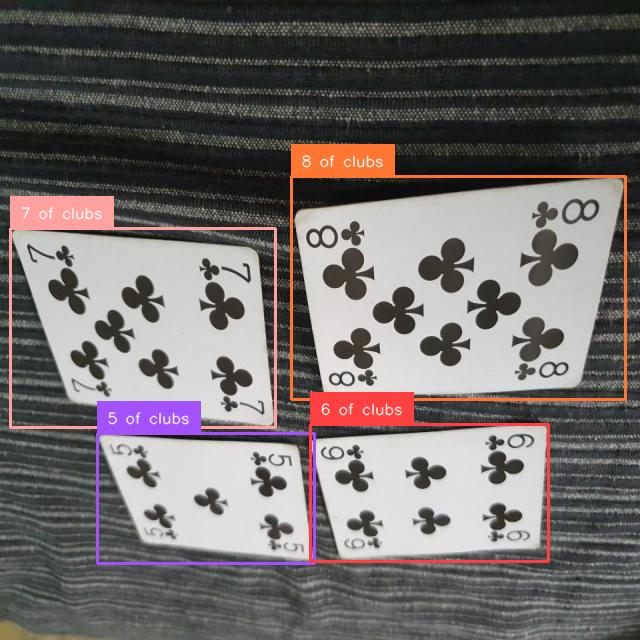

CPU times: user 29min 2s, sys: 9min 55s, total: 38min 57s
Wall time: 37min 19s


In [ ]:
# @title Run train loop

%%time

EPOCHS = 10
LR = 5e-6

train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)

## Fine-tuned model evaluation

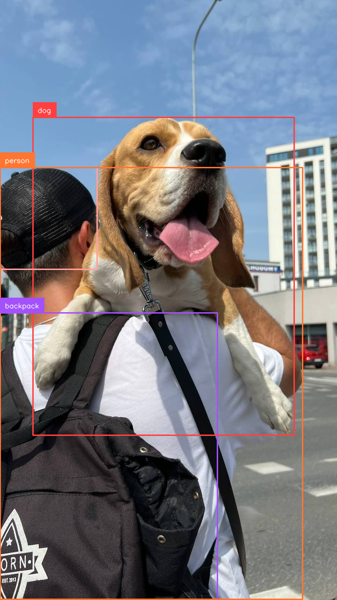

In [ ]:
# @title Check if the model can still detect objects outside of the custom dataset

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<OD>"
text = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = peft_model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

**NOTE:** It seems that the model can still detect classes that don't belong to our custom dataset.

In [ ]:
# @title Collect predictions

PATTERN = r'([a-zA-Z0-9 ]+ of [a-zA-Z0-9 ]+)<loc_\d+>'

def extract_classes(dataset: DetectionDataset):
    class_set = set()
    for i in range(len(dataset.dataset)):
        image, data = dataset.dataset[i]
        suffix = data["suffix"]
        classes = re.findall(PATTERN, suffix)
        class_set.update(classes)
    return sorted(class_set)

CLASSES = extract_classes(train_dataset)

targets = []
predictions = []

for i in range(len(val_dataset.dataset)):
    image, data = val_dataset.dataset[i]
    prefix = data['prefix']
    suffix = data['suffix']

    inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    prediction = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
    prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, prediction, resolution_wh=image.size)
    prediction = prediction[np.isin(prediction['class_name'], CLASSES)]
    prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
    prediction.confidence = np.ones(len(prediction))

    target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
    target = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, target, resolution_wh=image.size)
    target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])

    targets.append(target)
    predictions.append(prediction)

In [ ]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.49
map50: 0.53
map75: 0.53


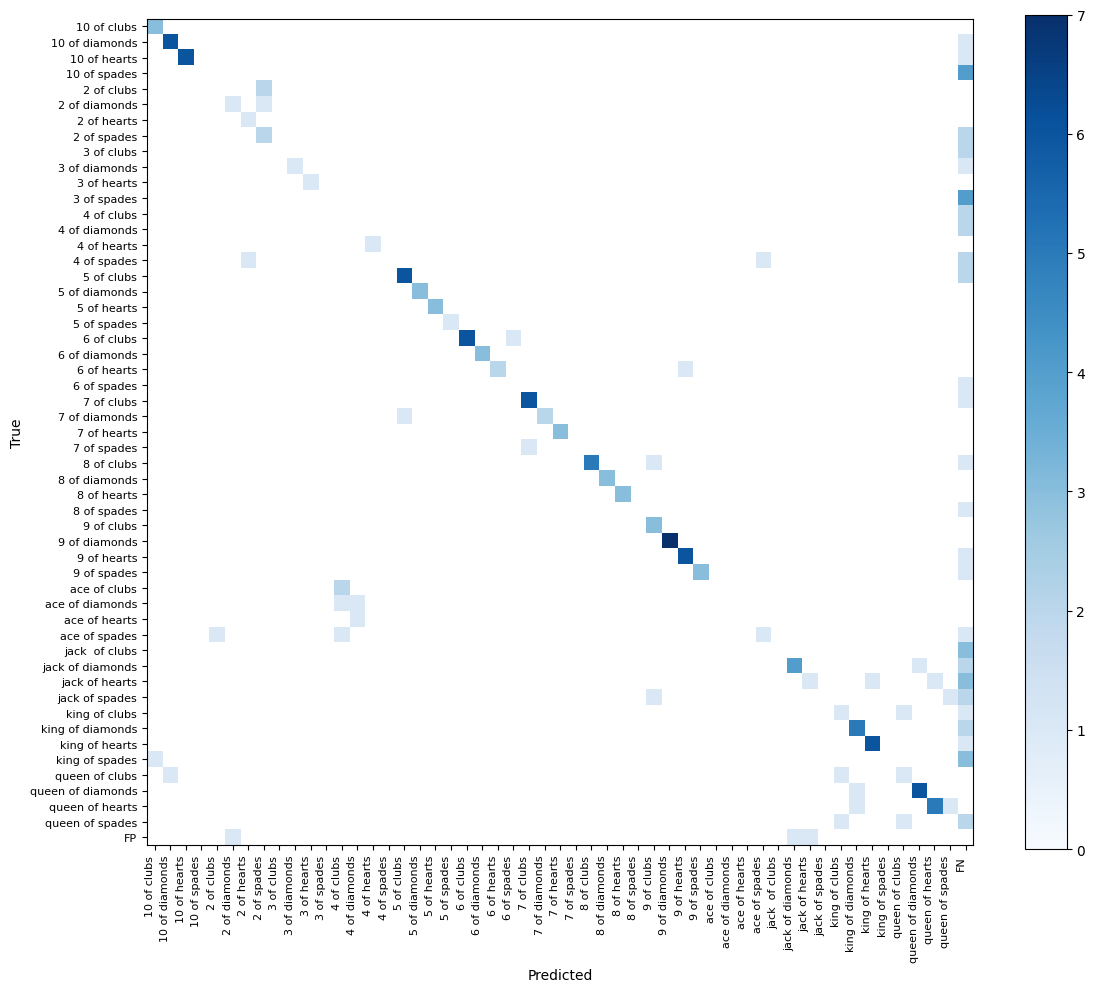

In [ ]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

## Save fine-tuned model on hard drive

In [ ]:
peft_model.save_pretrained("/content/florence2-lora")
processor.save_pretrained("/content/florence2-lora/")
!ls -la /content/florence2-lora/

total 11432
drwxr-xr-x 2 root root    4096 Jun 26 21:43 .
drwxr-xr-x 1 root root    4096 Jun 26 21:43 ..
-rw-r--r-- 1 root root     746 Jun 26 21:43 adapter_config.json
-rw-r--r-- 1 root root 7747264 Jun 26 21:43 adapter_model.safetensors
-rw-r--r-- 1 root root   22410 Jun 26 21:43 added_tokens.json
-rw-r--r-- 1 root root  456318 Jun 26 21:43 merges.txt
-rw-r--r-- 1 root root     947 Jun 26 21:43 preprocessor_config.json
-rw-r--r-- 1 root root    5102 Jun 26 21:43 README.md
-rw-r--r-- 1 root root  146627 Jun 26 21:43 special_tokens_map.json
-rw-r--r-- 1 root root  197658 Jun 26 21:43 tokenizer_config.json
-rw-r--r-- 1 root root 2297961 Jun 26 21:43 tokenizer.json
-rw-r--r-- 1 root root  798293 Jun 26 21:43 vocab.json


## Upload model to Roboflow (optional)

You can deploy your Florence-2 object detection model on your own hardware (i.e. a cloud GPu server or an NVIDIA Jetson) with Roboflow Inference, an open source computer vision inference server.

To deploy your model, you will need a [free Roboflow account](https://app.roboflow.com).

To get started, [create a new Project in Roboflow](https://docs.roboflow.com/datasets/create-a-project) if you don't already have one. Then, upload the dataset you used to train your model. Then, create a dataset Version, which is a snapshot of your dataset with which your model will be associated in Roboflow.

You can read our full [Deploy Florence-2 with Roboflow](https://blog.roboflow.com/deploy-florence-2-with-roboflow/) guide for step-by-step instructions of these steps.

Once you have trained your model A, you can upload it to Roboflow using the following code:

In [ ]:
import roboflow

rf = Roboflow(api_key="API_KEY")
project = rf.workspace("workspace-id").project("project-id")
version = project.version(VERSION)

version.deploy(model_type="florence-2", model_path="/content/florence2-lora")

Above, replace:

- API_KEY with your [Roboflow API key](https://docs.roboflow.com/api-reference/authentication#retrieve-an-api-key).
- workspace-id and project-id with your [workspace and project IDs](https://docs.roboflow.com/api-reference/workspace-and-project-ids).
- VERSION with your project version.

If you are not using our notebook, replace /content/florence2-lora with the directory where you saved your model weights.

When you run the code above, the model will be uploaded to Roboflow. It will take a few minutes for the model to be processed before it is ready for use.

Your model will be uploaded to Roboflow.

## Deploy to your hardware

Once your model has been processed, you can download it to any device on which you want to deploy your model. Deployment is supported through Roboflow Inference, our open source computer vision inference server.

Inference can be run as a microservice with Docker, ideal for large deployments where you may need a centralized server on which to run inference, or when you want to run Inference in an isolated container. You can also directly integrate Inference into your project through the Inference Python SDK.

For this guide, we will show how to deploy the model with the Python SDK.

First, install inference:

In [ ]:
!pip install inference

Then, create a new Python file and add the following code:

In [ ]:
import os
from inference import get_model
from PIL import Image
import json

lora_model = get_model("model-id/version-id", api_key="KEY")

image = Image.open("containers.png")
response = lora_model.infer(image)
print(response)

In the code avove, we load our model, run it on an image, then plot the predictions with the supervision Python package.

When you first run the code, your model weights will be downloaded and cached to your device for subsequent runs. This process may take a few minutes depending on the strength of your internet connection.

# Congratulations

⭐️ If you enjoyed this notebook, [**star the Roboflow Notebooks repo**](https://https://github.com/roboflow/notebooks) (and [**supervision**](https://github.com/roboflow/supervision) while you're at it) and let us know what tutorials you'd like to see us do next. ⭐️